### Problem Definition

Given clinical parameters about a person, can we predict whether or not they have heart disease?

### I have also created a Inference Pipeline using Luigi and a Streamlit web app for real time predictions. 

You can try it at the below links - 


https://heart-disease-diagnostics.herokuapp.com/

https://github.com/Nikhilkohli1/Heart-Disease-Diagnosis-Assistant



### What I will be doing in this notebook - 

1. EDA (Exploratory Data Analysis)
2. Data Pre-processing 
3. Predictive Modeling - I will train 4 different algorithms on 4 different feature sets after doing extensive feature selection. 
4. Model Selection 
5. Ensemble Max Vote - from the best models, I will create a simple Ensemble Max Voting approach to make predictions using top 3 best models



### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression


import warnings
warnings.filterwarnings("ignore")

### Load the UCI heart Disease Dataset

In [2]:
df_heart = pd.read_csv('/kaggle/input/heart-disease-uci/heart.csv')
df_heart.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
df_heart.shape

(303, 14)

### Descriptive Statistics & Data Cleaning

In [4]:
df_heart = df_heart.rename(columns= {'cp':'chest_pain_type','trestbps':'resting_BP','chol':'serum_cholestoral','fbs':'fasting_blood_sugar','restecg':'resting_ECG',
                                     'thalach':'max_heart_rate','exang':'exercise_induced_angina',
                                     'ca':'major_vessels_count','thal':'thalium_stress'})
df_heart.columns

Index(['age', 'sex', 'chest_pain_type', 'resting_BP', 'serum_cholestoral',
       'fasting_blood_sugar', 'resting_ECG', 'max_heart_rate',
       'exercise_induced_angina', 'oldpeak', 'slope', 'major_vessels_count',
       'thalium_stress', 'target'],
      dtype='object')

In [5]:
df_heart.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      303 non-null    int64  
 1   sex                      303 non-null    int64  
 2   chest_pain_type          303 non-null    int64  
 3   resting_BP               303 non-null    int64  
 4   serum_cholestoral        303 non-null    int64  
 5   fasting_blood_sugar      303 non-null    int64  
 6   resting_ECG              303 non-null    int64  
 7   max_heart_rate           303 non-null    int64  
 8   exercise_induced_angina  303 non-null    int64  
 9   oldpeak                  303 non-null    float64
 10  slope                    303 non-null    int64  
 11  major_vessels_count      303 non-null    int64  
 12  thalium_stress           303 non-null    int64  
 13  target                   303 non-null    int64  
dtypes: float64(1), int64(13)
m

In [6]:
df_heart.isnull().sum()

age                        0
sex                        0
chest_pain_type            0
resting_BP                 0
serum_cholestoral          0
fasting_blood_sugar        0
resting_ECG                0
max_heart_rate             0
exercise_induced_angina    0
oldpeak                    0
slope                      0
major_vessels_count        0
thalium_stress             0
target                     0
dtype: int64

No Null values,lucky!

### Categorical Discrete & Continous Variables

In [7]:
categorical_cols = []
continous_cols = []

for column in df_heart.columns:
    if(len(df_heart[column].unique()) <= 10):
        categorical_cols.append(column)
    else:
        continous_cols.append(column)

In [8]:
categorical_cols

['sex',
 'chest_pain_type',
 'fasting_blood_sugar',
 'resting_ECG',
 'exercise_induced_angina',
 'slope',
 'major_vessels_count',
 'thalium_stress',
 'target']

In [9]:
continous_cols

['age', 'resting_BP', 'serum_cholestoral', 'max_heart_rate', 'oldpeak']

In [10]:
df_heart_tmp = df_heart.copy()
for cols in categorical_cols:
    if(cols != 'target'):
        df_heart_tmp[cols] = df_heart_tmp[cols].astype('object')

In [11]:
df_heart_tmp.dtypes


age                          int64
sex                         object
chest_pain_type             object
resting_BP                   int64
serum_cholestoral            int64
fasting_blood_sugar         object
resting_ECG                 object
max_heart_rate               int64
exercise_induced_angina     object
oldpeak                    float64
slope                       object
major_vessels_count         object
thalium_stress              object
target                       int64
dtype: object

In [12]:
df_heart_tmp.describe()


,age,resting_BP,serum_cholestoral,max_heart_rate,oldpeak,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,131.623762,246.264026,149.646865,1.039604,0.544554
std,9.082101,17.538143,51.830751,22.905161,1.161075,0.498835
min,29.000000,94.000000,126.000000,71.000000,0.000000,0.000000
25%,47.500000,120.000000,211.000000,133.500000,0.000000,0.000000
50%,55.000000,130.000000,240.000000,153.000000,0.800000,1.000000
75%,61.000000,140.000000,274.500000,166.000000,1.600000,1.000000
max,77.000000,200.000000,564.000000,202.000000,6.200000,1.000000


### Data Redundancy(Constant & Quasi Constant variables)

In [13]:
df_heart_tmp.describe(include='object')


,sex,chest_pain_type,fasting_blood_sugar,resting_ECG,exercise_induced_angina,slope,major_vessels_count,thalium_stress
count,303,303,303,303,303,303,303,303
unique,2,4,2,3,2,3,5,4
top,1,0,0,1,0,2,0,2
freq,207,143,258,152,204,142,175,166


These are no variables with only 1 unique value or Quasi constant(>99% values are constant), so we are good with Redundancy

### Target Distribution

In [14]:
df_heart.target.value_counts()


1    165
0    138
Name: target, dtype: int64

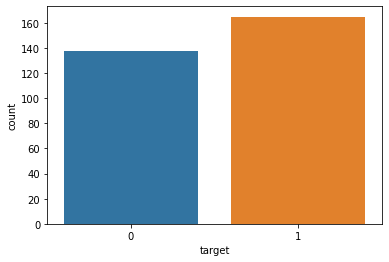

In [15]:
sns.countplot(df_heart['target'])


The data is not highly imbalanced, but we can try to balance it using SMOTE Oversampling if we do not get a good accuracy with this.

## Exploratory Data Analysis

### Continous Features

Let's check the distribution for continous features

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5757bce750>,
      dtype=object)

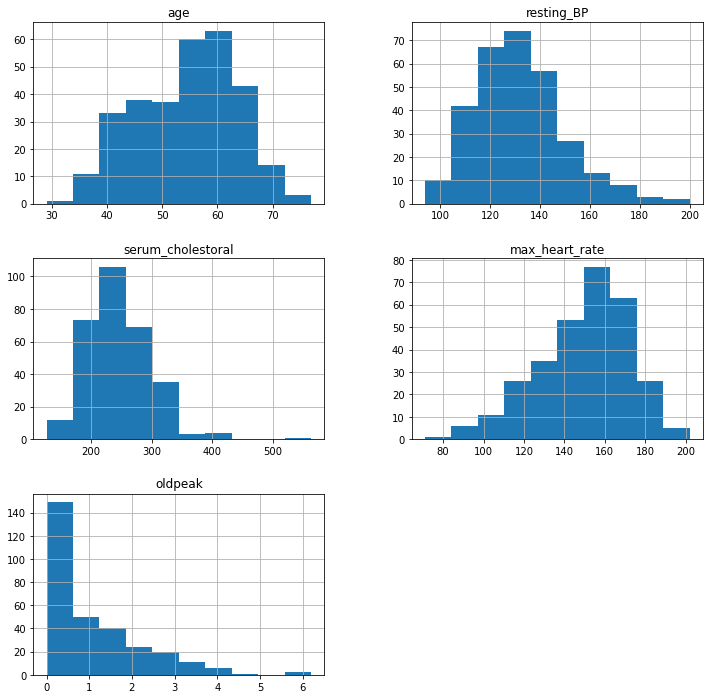

In [16]:
df_heart.hist(column=continous_cols, figsize=(12,12))


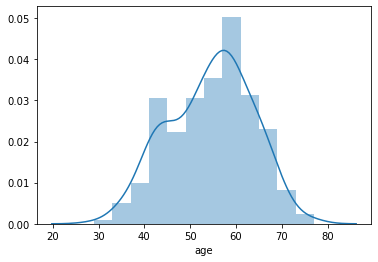

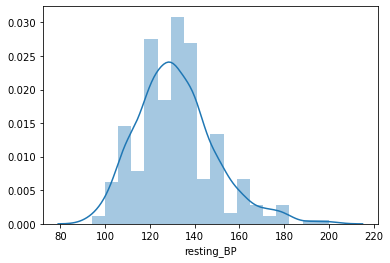

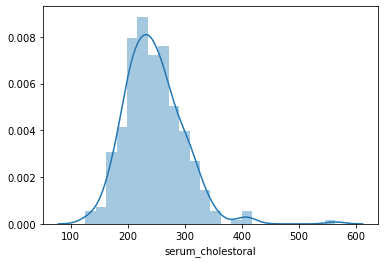

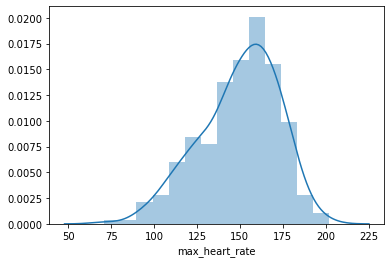

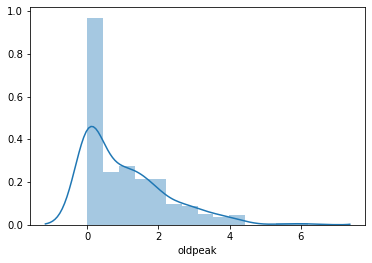

In [17]:
for index, column in enumerate(continous_cols):
    plt.figure(index)
    sns.distplot(df_heart[column])

Old Peak seems to be highly skewed, lets see the Skew for each feature. The skew result show a positive (right) or negative (left) skew. Values closer to zero show less skew.

In [18]:
df_heart[continous_cols].skew()

age                 -0.202463
resting_BP           0.713768
serum_cholestoral    1.143401
max_heart_rate      -0.537410
oldpeak              1.269720
dtype: float64

As evident from the Skew values above for continous features, oldpeak & serum cholestoral are right skewed. We can apply Log Transformation to these variables while Preprocessing data for Machine Learning.

In [19]:
### Distribution of Categorical Values

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5757343d10>,
      dtype=object)

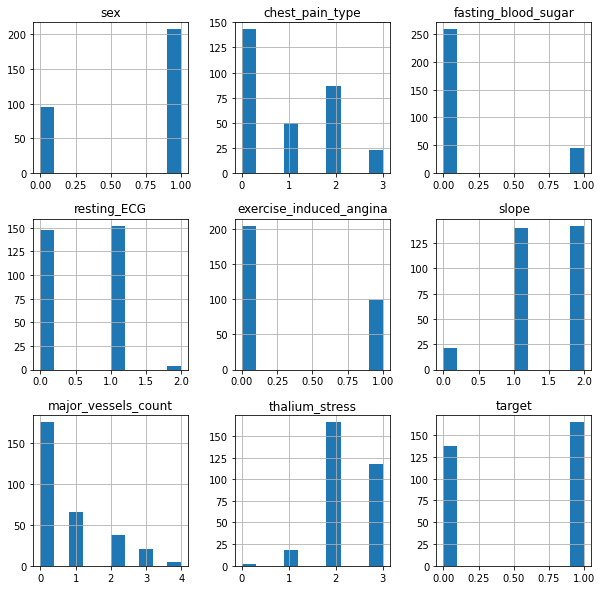

In [20]:
df_heart.hist(column=categorical_cols, figsize=(10,10))


### Associations & Correlation between variables

In [21]:
df_heart_tmp.describe().columns


Index(['age', 'resting_BP', 'serum_cholestoral', 'max_heart_rate', 'oldpeak',
       'target'],
      dtype='object')

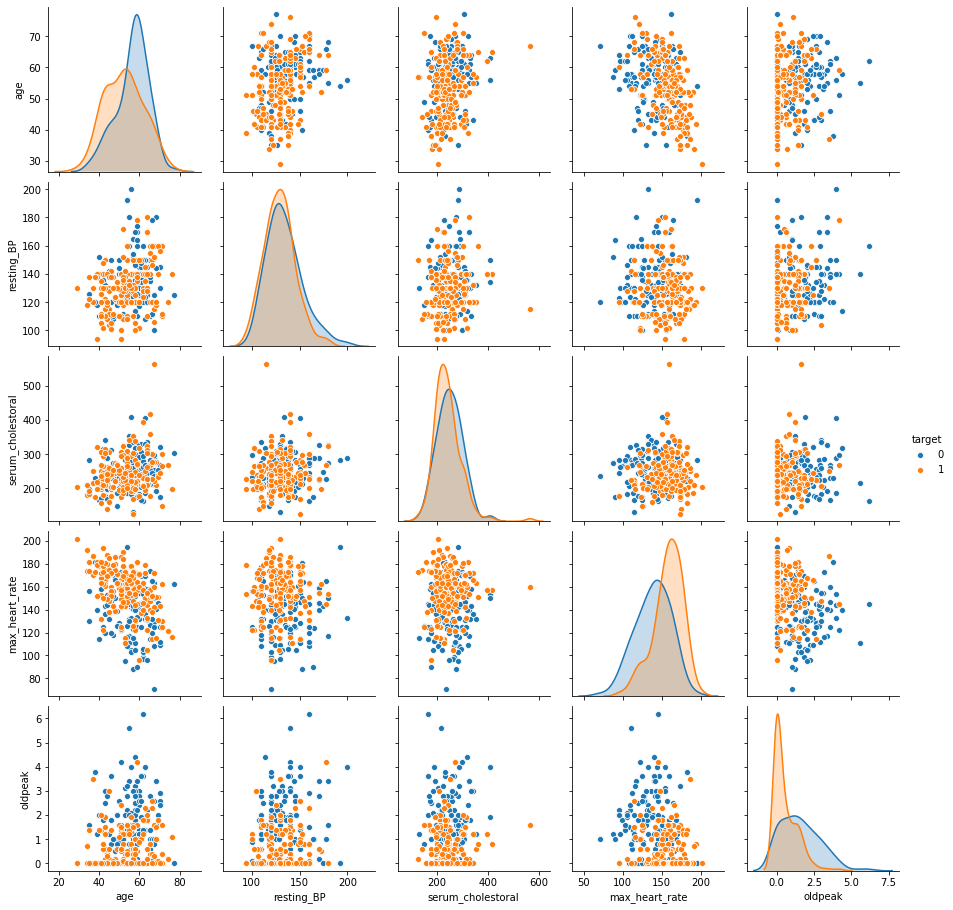

In [22]:
sns.pairplot(df_heart_tmp[df_heart_tmp.describe().columns], hue='target')

In [23]:
df_heart.corr()


,age,sex,chest_pain_type,resting_BP,serum_cholestoral,fasting_blood_sugar,resting_ECG,max_heart_rate,exercise_induced_angina,oldpeak,slope,major_vessels_count,thalium_stress,target
age,1.000000,-0.098447,-0.068653,0.279351,0.213678,0.121308,-0.116211,-0.398522,0.096801,0.210013,-0.168814,0.276326,0.068001,-0.225439
sex,-0.098447,1.000000,-0.049353,-0.056769,-0.197912,0.045032,-0.058196,-0.044020,0.141664,0.096093,-0.030711,0.118261,0.210041,-0.280937
chest_pain_type,-0.068653,-0.049353,1.000000,0.047608,-0.076904,0.094444,0.044421,0.295762,-0.394280,-0.149230,0.119717,-0.181053,-0.161736,0.433798
resting_BP,0.279351,-0.056769,0.047608,1.000000,0.123174,0.177531,-0.114103,-0.046698,0.067616,0.193216,-0.121475,0.101389,0.062210,-0.144931
serum_cholestoral,0.213678,-0.197912,-0.076904,0.123174,1.000000,0.013294,-0.151040,-0.009940,0.067023,0.053952,-0.004038,0.070511,0.098803,-0.085239
fasting_blood_sugar,0.121308,0.045032,0.094444,0.177531,0.013294,1.000000,-0.084189,-0.008567,0.025665,0.005747,-0.059894,0.137979,-0.032019,-0.028046
resting_ECG,-0.116211,-0.058196,0.044421,-0.114103,-0.151040,-0.084189,1.000000,0.044123,-0.070733,-0.058770,0.093045,-0.072042,-0.011981,0.137230
max_heart_rate,-0.398522,-0.044020,0.295762,-0.046698,-0.009940,-0.008567,0.044123,1.000000,-0.378812,-0.344187,0.386784,-0.213177,-0.096439,0.421741
exercise_induced_angina,0.096801,0.141664,-0.394280,0.067616,0.067023,0.025665,-0.070733,-0.378812,1.000000,0.288223,-0.257748,0.115739,0.206754,-0.436757
oldpeak,0.210013,0.096093,-0.149230,0.193216,0.053952,0.005747,-0.058770,-0.344187,0.288223,1.000000,-0.577537,0.222682,0.210244,-0.430696


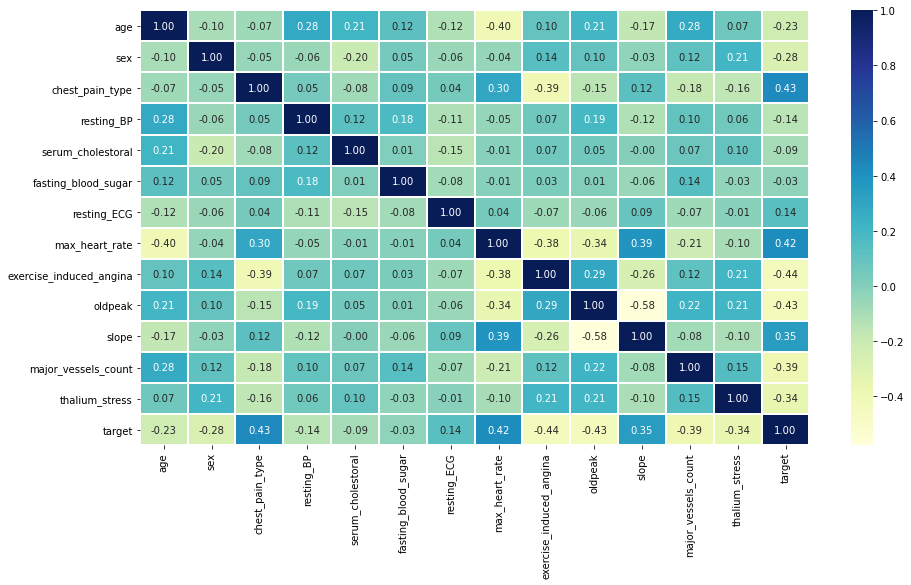

In [24]:
plt.figure(figsize=(15,8))
sns.heatmap(df_heart.corr(), annot=True, linewidths=1, linecolor='white', fmt=".2f",
                 cmap="YlGnBu")

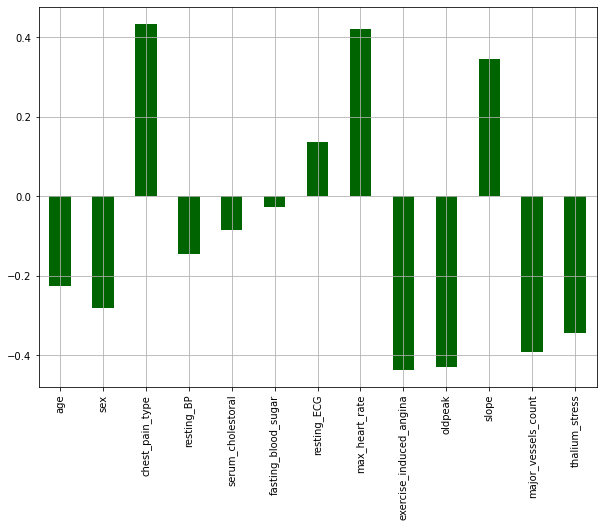

In [25]:
df_heart.drop('target', axis=1).corrwith(df_heart.target).plot(kind='bar', grid=True, figsize=(10, 7), color='darkgreen')


Most features have a significant correlation with the Target variable except Fasting Blood Sugar, Resting ECG and Serum Cholestoral. Chest pain type and Max heart rate has a high positive correlation with the target

### Analysing Relationship between continous variables & Target

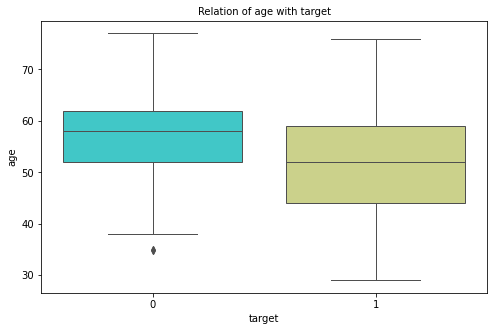

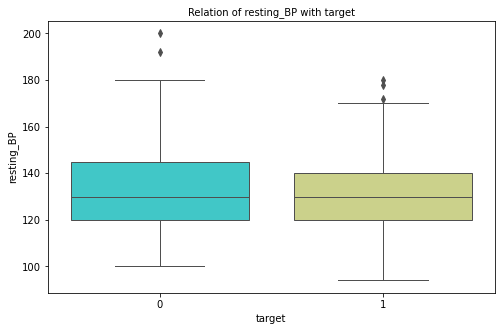

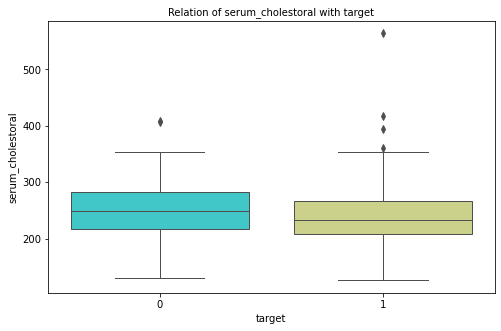

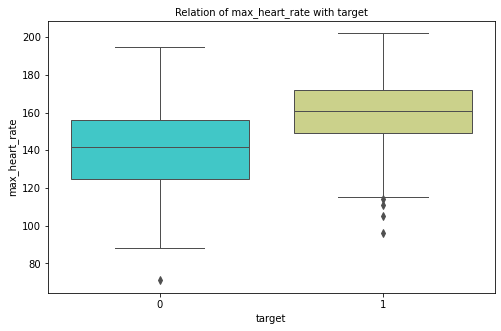

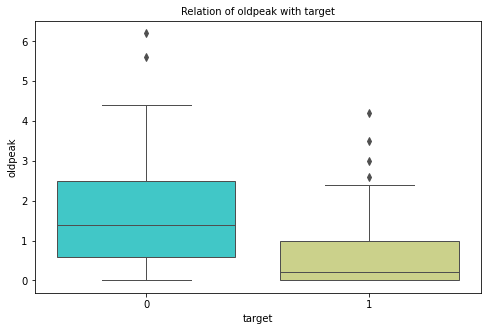

In [26]:
for index,column in enumerate(continous_cols):
    plt.figure(index, figsize=(8,5))
    sns.boxplot(x=df_heart.target, y=column, data=df_heart, palette='rainbow',linewidth=1)
    plt.title('Relation of {} with target'.format(column), fontsize = 10)

There are some unusual or rare values like in Cholestoral(400-500) and resting BP(200) but these are possible values and not Data collection errors. So we should not remove any of these even when they look like outliers.

### Swarmplots

Let me also look at the relationship between few variables and target with Swarm plots.

This approach adjusts the points along the categorical axis using an algorithm that prevents them from overlapping. It can give a better representation of the distribution of observations, although it only works well for relatively small datasets.

<Figure size 504x360 with 0 Axes>

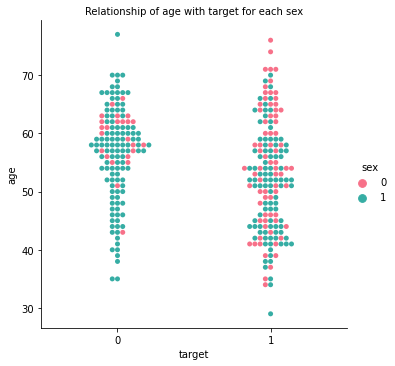

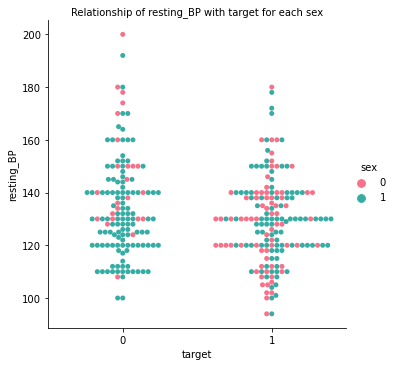

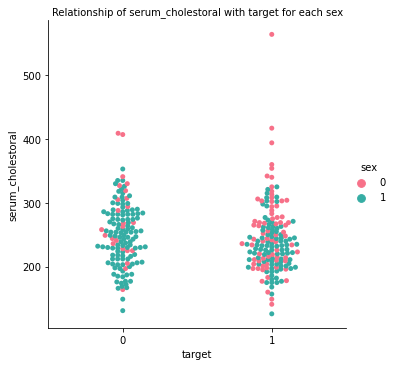

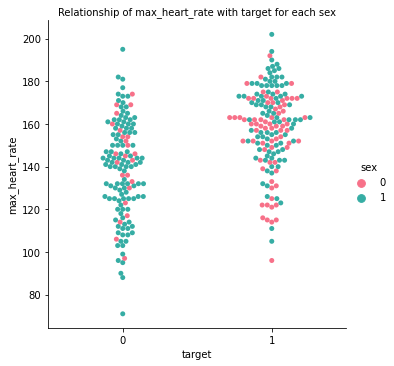

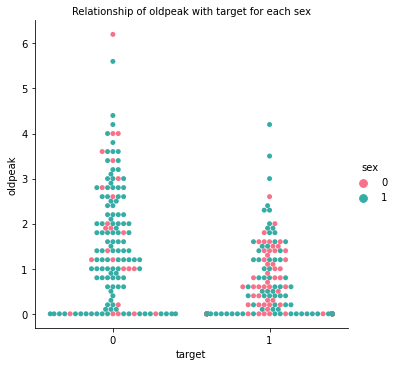

In [27]:
for index,column in enumerate(continous_cols):
    plt.figure(index,figsize=(7,5))
    sns.catplot(x='target', y=column, hue='sex', kind='swarm', data=df_heart, palette='husl')
    plt.title('Relationship of {} with target for each sex'.format(column), fontsize = 10)

### Observations -

***Age***
- On an Average people above the age of 50 are at risk of having a heart disease when combined with other factors. Age alone is not a good predictor of heart disease as evident from the box plot and Swarm plot.

***Resting Blood pressure***
- Anything above 130-140 (in mm Hg) is a cause for concern.

***Serum Cholestoral***
- Cholestoral (LDL + HDL + Triglysrides) above 300 is definitely a concern, below that is a concern when combined with other factors.

***Thalach(Maximum Heart ate)***
- There is a Strong correlation between the Heart Disease and max heart rate. People with Max heart rate above 150-160 are more likely to suffer from a Heart Disease.

### Analysing Relationship between Categorical variables & Target

In [28]:
categorical_cols.pop(8)


'target'

#### Number of Labels in each Categorical feature : Cardinality

In [29]:
for var in categorical_cols:
    print('Cardinality of {1} is {0}'.format(len(df_heart[var].unique()), var))

Cardinality of sex is 2
Cardinality of chest_pain_type is 4
Cardinality of fasting_blood_sugar is 2
Cardinality of resting_ECG is 3
Cardinality of exercise_induced_angina is 2
Cardinality of slope is 3
Cardinality of major_vessels_count is 5
Cardinality of thalium_stress is 4


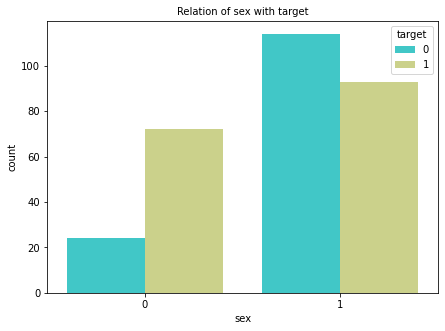

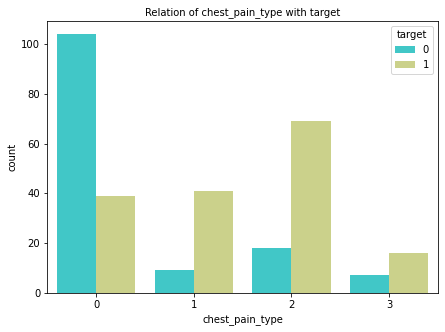

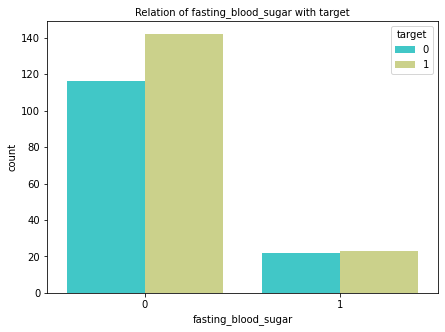

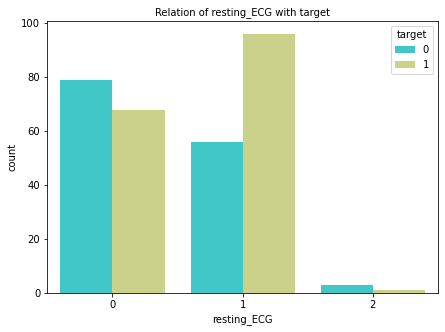

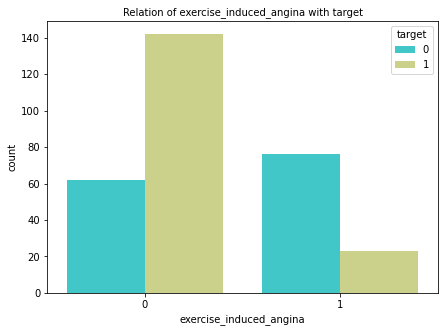

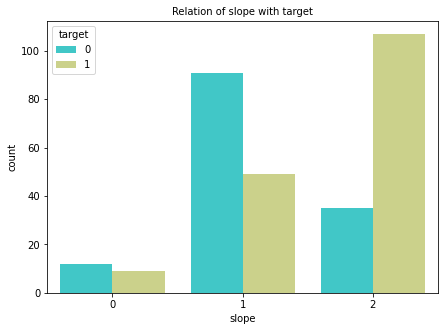

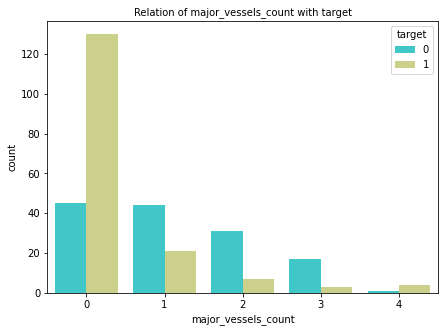

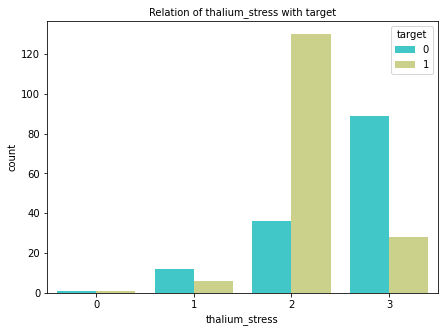

In [30]:
for index,column in enumerate(categorical_cols):
    plt.figure(index,figsize=(7,5))
    sns.countplot(x=column, hue='target', data=df_heart, palette='rainbow')
    plt.title('Relation of {} with target'.format(column), fontsize = 10)

### Observation for Categorical variables -

- Sex - Females are more likely to have a Heart Disease than Males.

- Chest Pain type - People with Chest Pain type 1,2,3 have more chance of having a Heart Disease.

- Resting ECG - People with value 1 for resting ECG(abnormal Heart beat) are more likely to have a heart disease.

- Exercise Induced Angina - Poeple with No Exercise Induced Angina(0) have heart diseases more than others who have Angina due to exercise. This seems a little contradictory between.

- Slope People with Slope value equal to 2 are more likely to have a Heart Disease than people with Slope value 0 or 1

- Major vessel Count - This has a negative relation with Heart disease. The lesser Number of Major vessels, the more chances are of Heart Disease.

- Thalium Stress ST Depression - Poeple with value 2 or 3 are more likely to have Heart Disease

### Data Preprocessing & Feature Engineering
We need to do three things as part of Data Preprocessing before we can build Machine Learning models for Classification -

- 1. One Hot Encoding - Creation of dummy variables for Categorical Variables with more than 2 classes

- 2. Feature Scaling - We will be using distance based algorithms as well like KNN, so scaling is required

Dummy Variable -
As Sex, Fasting Blood Sugar & Exercise induced Angina contain only 2 unique values (0, 1), we do not need to create dummy variable for them. So there are 5 variables which need to be encoded.

I will also drop the first column of each as after encoding, it can cause dummy variable trap.

In [31]:
categorical_dummy = [
 'chest_pain_type',
 'resting_ECG',
 'slope',
 'major_vessels_count',
 'thalium_stress']

In [32]:
df_heart = pd.get_dummies(df_heart, columns=categorical_dummy, drop_first=True )
df_heart.columns

Index(['age', 'sex', 'resting_BP', 'serum_cholestoral', 'fasting_blood_sugar',
       'max_heart_rate', 'exercise_induced_angina', 'oldpeak', 'target',
       'chest_pain_type_1', 'chest_pain_type_2', 'chest_pain_type_3',
       'resting_ECG_1', 'resting_ECG_2', 'slope_1', 'slope_2',
       'major_vessels_count_1', 'major_vessels_count_2',
       'major_vessels_count_3', 'major_vessels_count_4', 'thalium_stress_1',
       'thalium_stress_2', 'thalium_stress_3'],
      dtype='object')

In [33]:
len(df_heart.columns)


23

We have 23 features to play with now. Lets continue with the Preprocessing Steps

In [34]:
target = df_heart.target
features = df_heart.drop(columns=['target'])

### Feature Scaling
I have tried both Robust Scaling as well as Min Max Scaling, MinMax scalign works better for this problem, so i am using this.
Robust Scaler is robust to outliers.

In [35]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
scaler = MinMaxScaler()
features_SS = scaler.fit_transform(features)
features_SS = pd.DataFrame(features_SS, columns=features.columns)

### Train Test Splitting

In [36]:
X_train, X_test, Y_train, Y_test = train_test_split(features_SS, target, test_size=0.2, random_state=42)

In [37]:
Y_train.value_counts()


1    133
0    109
Name: target, dtype: int64

In [38]:
X_train.head()


,age,sex,resting_BP,serum_cholestoral,fasting_blood_sugar,max_heart_rate,exercise_induced_angina,oldpeak,chest_pain_type_1,chest_pain_type_2,...,resting_ECG_2,slope_1,slope_2,major_vessels_count_1,major_vessels_count_2,major_vessels_count_3,major_vessels_count_4,thalium_stress_1,thalium_stress_2,thalium_stress_3
132,0.270833,1.0,0.245283,0.385845,0.0,0.694656,0.0,0.000000,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
202,0.604167,1.0,0.528302,0.328767,0.0,0.305344,1.0,0.129032,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
196,0.354167,1.0,0.528302,0.239726,0.0,0.580153,0.0,0.580645,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
75,0.541667,0.0,0.386792,0.283105,0.0,0.687023,0.0,0.225806,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
176,0.645833,1.0,0.216981,0.237443,1.0,0.679389,1.0,0.225806,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [39]:
X_train.shape, X_test.shape


((242, 22), (61, 22))

### Multicollinearity using VIF

In [40]:
# for each feature, calculate the VIF score
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['features'] = X_train.columns
vif.round(1)

,VIF Factor,features
0,13.5,age
1,4.3,sex
2,6.8,resting_BP
3,7.7,serum_cholestoral
4,1.3,fasting_blood_sugar
5,24.0,max_heart_rate
6,2.2,exercise_induced_angina
7,3.7,oldpeak
8,1.8,chest_pain_type_1
9,2.2,chest_pain_type_2


Only thalium Stress features have VIF factor greater. We can remove one and calculate the VIF again.

In [41]:
X = X_train.drop(columns=['thalium_stress_3'])

In [42]:
# for each feature, calculate the VIF score
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['features'] = X.columns
vif.round(1)

,VIF Factor,features
0,11.1,age
1,3.9,sex
2,6.7,resting_BP
3,7.7,serum_cholestoral
4,1.3,fasting_blood_sugar
5,15.1,max_heart_rate
6,2.0,exercise_induced_angina
7,3.3,oldpeak
8,1.8,chest_pain_type_1
9,2.2,chest_pain_type_2


Now, we have less VIF scores for all features.

### Feature Selection
I will using 3 techniques to select Features -

- Recursive feature Elimination with CV using Random Forest as estimator
- Recursive feature Elimination with CV using Logistic as estimator
- SelectFromModel using XGBoost

### Recursive Feature Elimination with Cross-validation

In [43]:
from sklearn.feature_selection import RFECV, SelectFromModel
from xgboost import XGBClassifier
import time

In [44]:
start = time.time()

rf = RandomForestClassifier(n_estimators=10, random_state=40)
rfe_rf = RFECV(estimator=rf, step=1, cv=5, n_jobs=-1)
rfe_rf.fit_transform(X_train, Y_train)

end = time.time()

In [45]:
print('Time Taken - {}'.format(str(end - start)))

Time Taken - 4.859782695770264


In [46]:
rfe_rf


RFECV(cv=5, estimator=RandomForestClassifier(n_estimators=10, random_state=40),
      n_jobs=-1)

In [47]:
rfe_rf.support_


array([ True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True, False,  True,  True,  True,  True, False,
       False, False,  True,  True])

In [48]:
rfe_rf_ranks = rfe_rf.ranking_
rfe_rf_ranks

array([1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 6, 1, 1, 1, 1, 2, 5, 4, 1, 1])

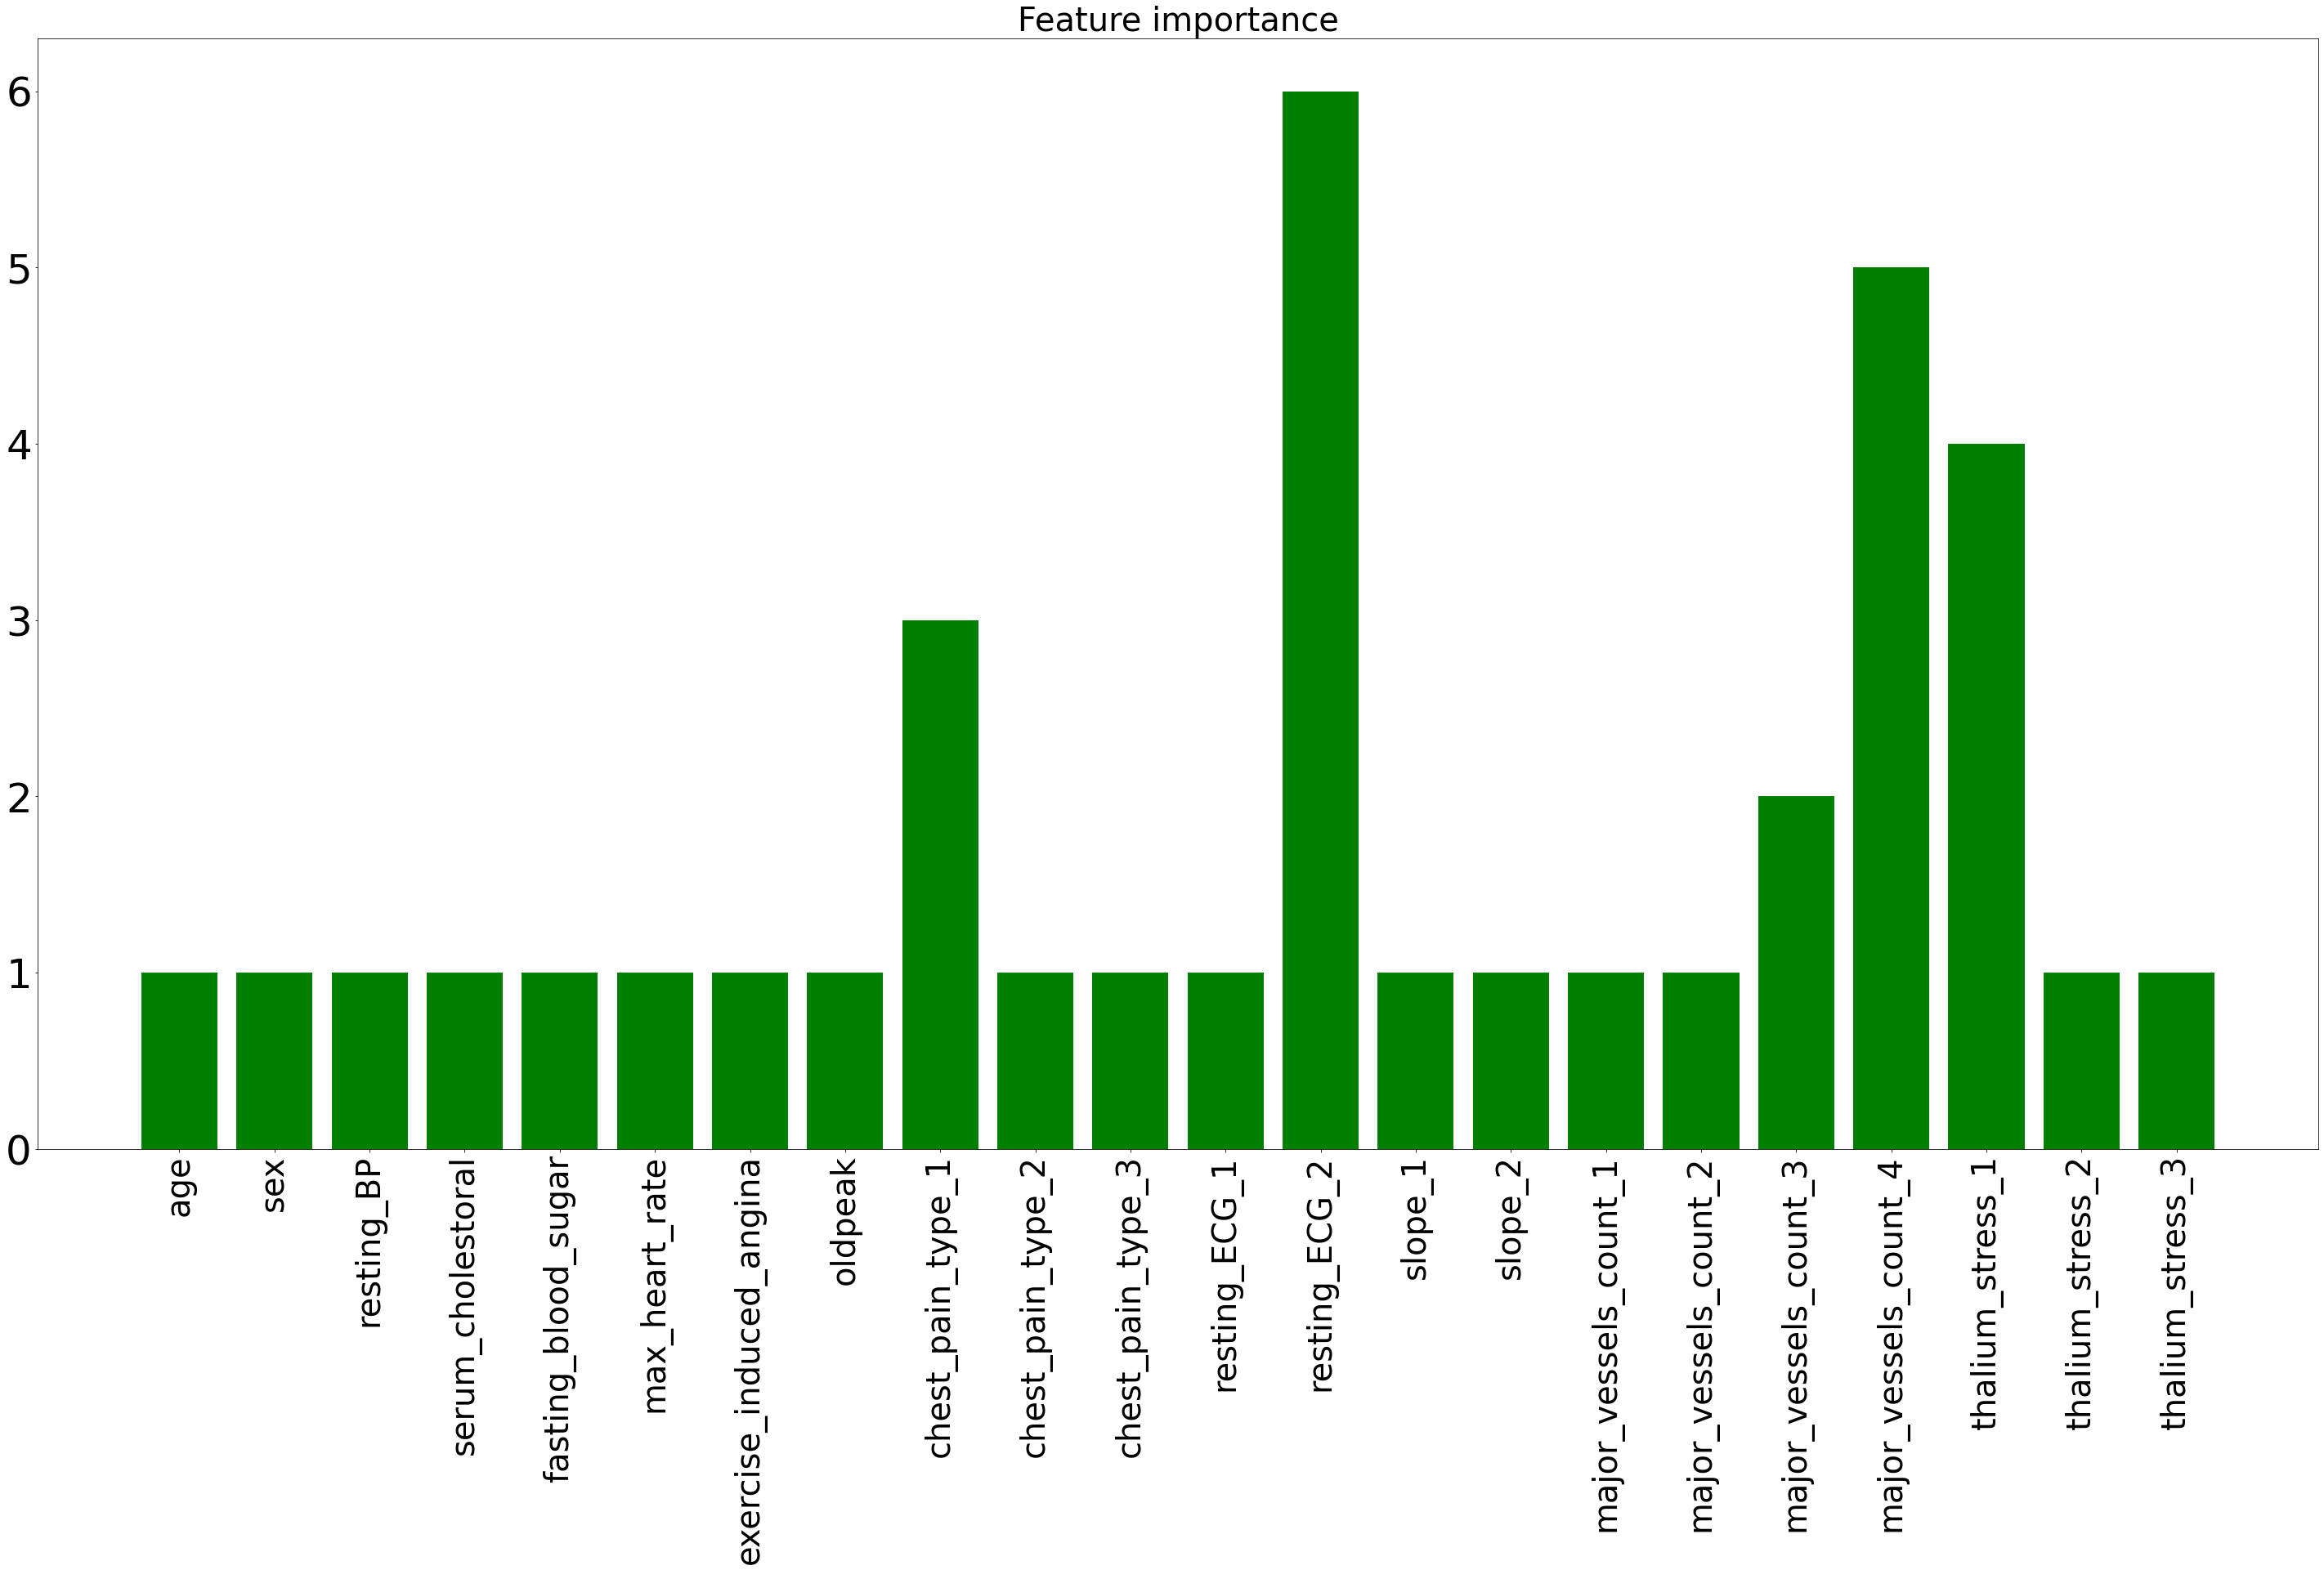

In [49]:
params = {'axes.labelsize': 280,'axes.titlesize':40, 'legend.fontsize': 18, 'xtick.labelsize': 40, 'ytick.labelsize': 50}
plt.figure(figsize=(50,25))
plt.rcParams.update(params)
ax = plt.bar(range(X_train.shape[1]), rfe_rf_ranks, color='green', align = 'center')
ax = plt.title('Feature importance')
ax = plt.xticks(range(X_train.shape[1]), X_train.columns, rotation=90)
plt.show()

In [50]:
feature_idx = rfe_rf.support_
feature_names = X_train.columns[feature_idx]
feature_names

Index(['age', 'sex', 'resting_BP', 'serum_cholestoral', 'fasting_blood_sugar',
       'max_heart_rate', 'exercise_induced_angina', 'oldpeak',
       'chest_pain_type_2', 'chest_pain_type_3', 'resting_ECG_1', 'slope_1',
       'slope_2', 'major_vessels_count_1', 'major_vessels_count_2',
       'thalium_stress_2', 'thalium_stress_3'],
      dtype='object')

Using RFECV gives us 19 features which are significant for prediction of Heart Diseases. The 3 features which are not so important as per this are resting_ECG_2, Major Vessel Count 3 & 4, which makes sense, as upto 2-3 vessel count is good, above 3 it does not really matter as you are less likely to have a heart disease in that case. Resting ECG as we saw, had a very low correlation with the target as we analysed through the heatmap.

I will also use SelectFromModel for selecting another set of features, and then see which one works best for this data.

In [51]:
start = time.time()

logit = LogisticRegression()
rfe_logit = RFECV(estimator=logit, step=1, cv=5, n_jobs=-1)
rfe_logit.fit_transform(X_train, Y_train)

end = time.time()

print('Time Taken - {}'.format(str(end - start)))
rfe_logit

Time Taken - 0.7791459560394287


RFECV(cv=5, estimator=LogisticRegression(), n_jobs=-1)

In [52]:
rfe_logit.support_

array([False,  True, False, False, False,  True,  True,  True, False,
        True,  True, False, False, False,  True,  True,  True,  True,
       False, False, False,  True])

In [53]:
rfe_logit_ranks = rfe_logit.ranking_
rfe_logit_ranks

array([12,  1,  2,  9,  8,  1,  1,  1,  3,  1,  1,  7, 10,  6,  1,  1,  1,
        1,  4, 11,  5,  1])

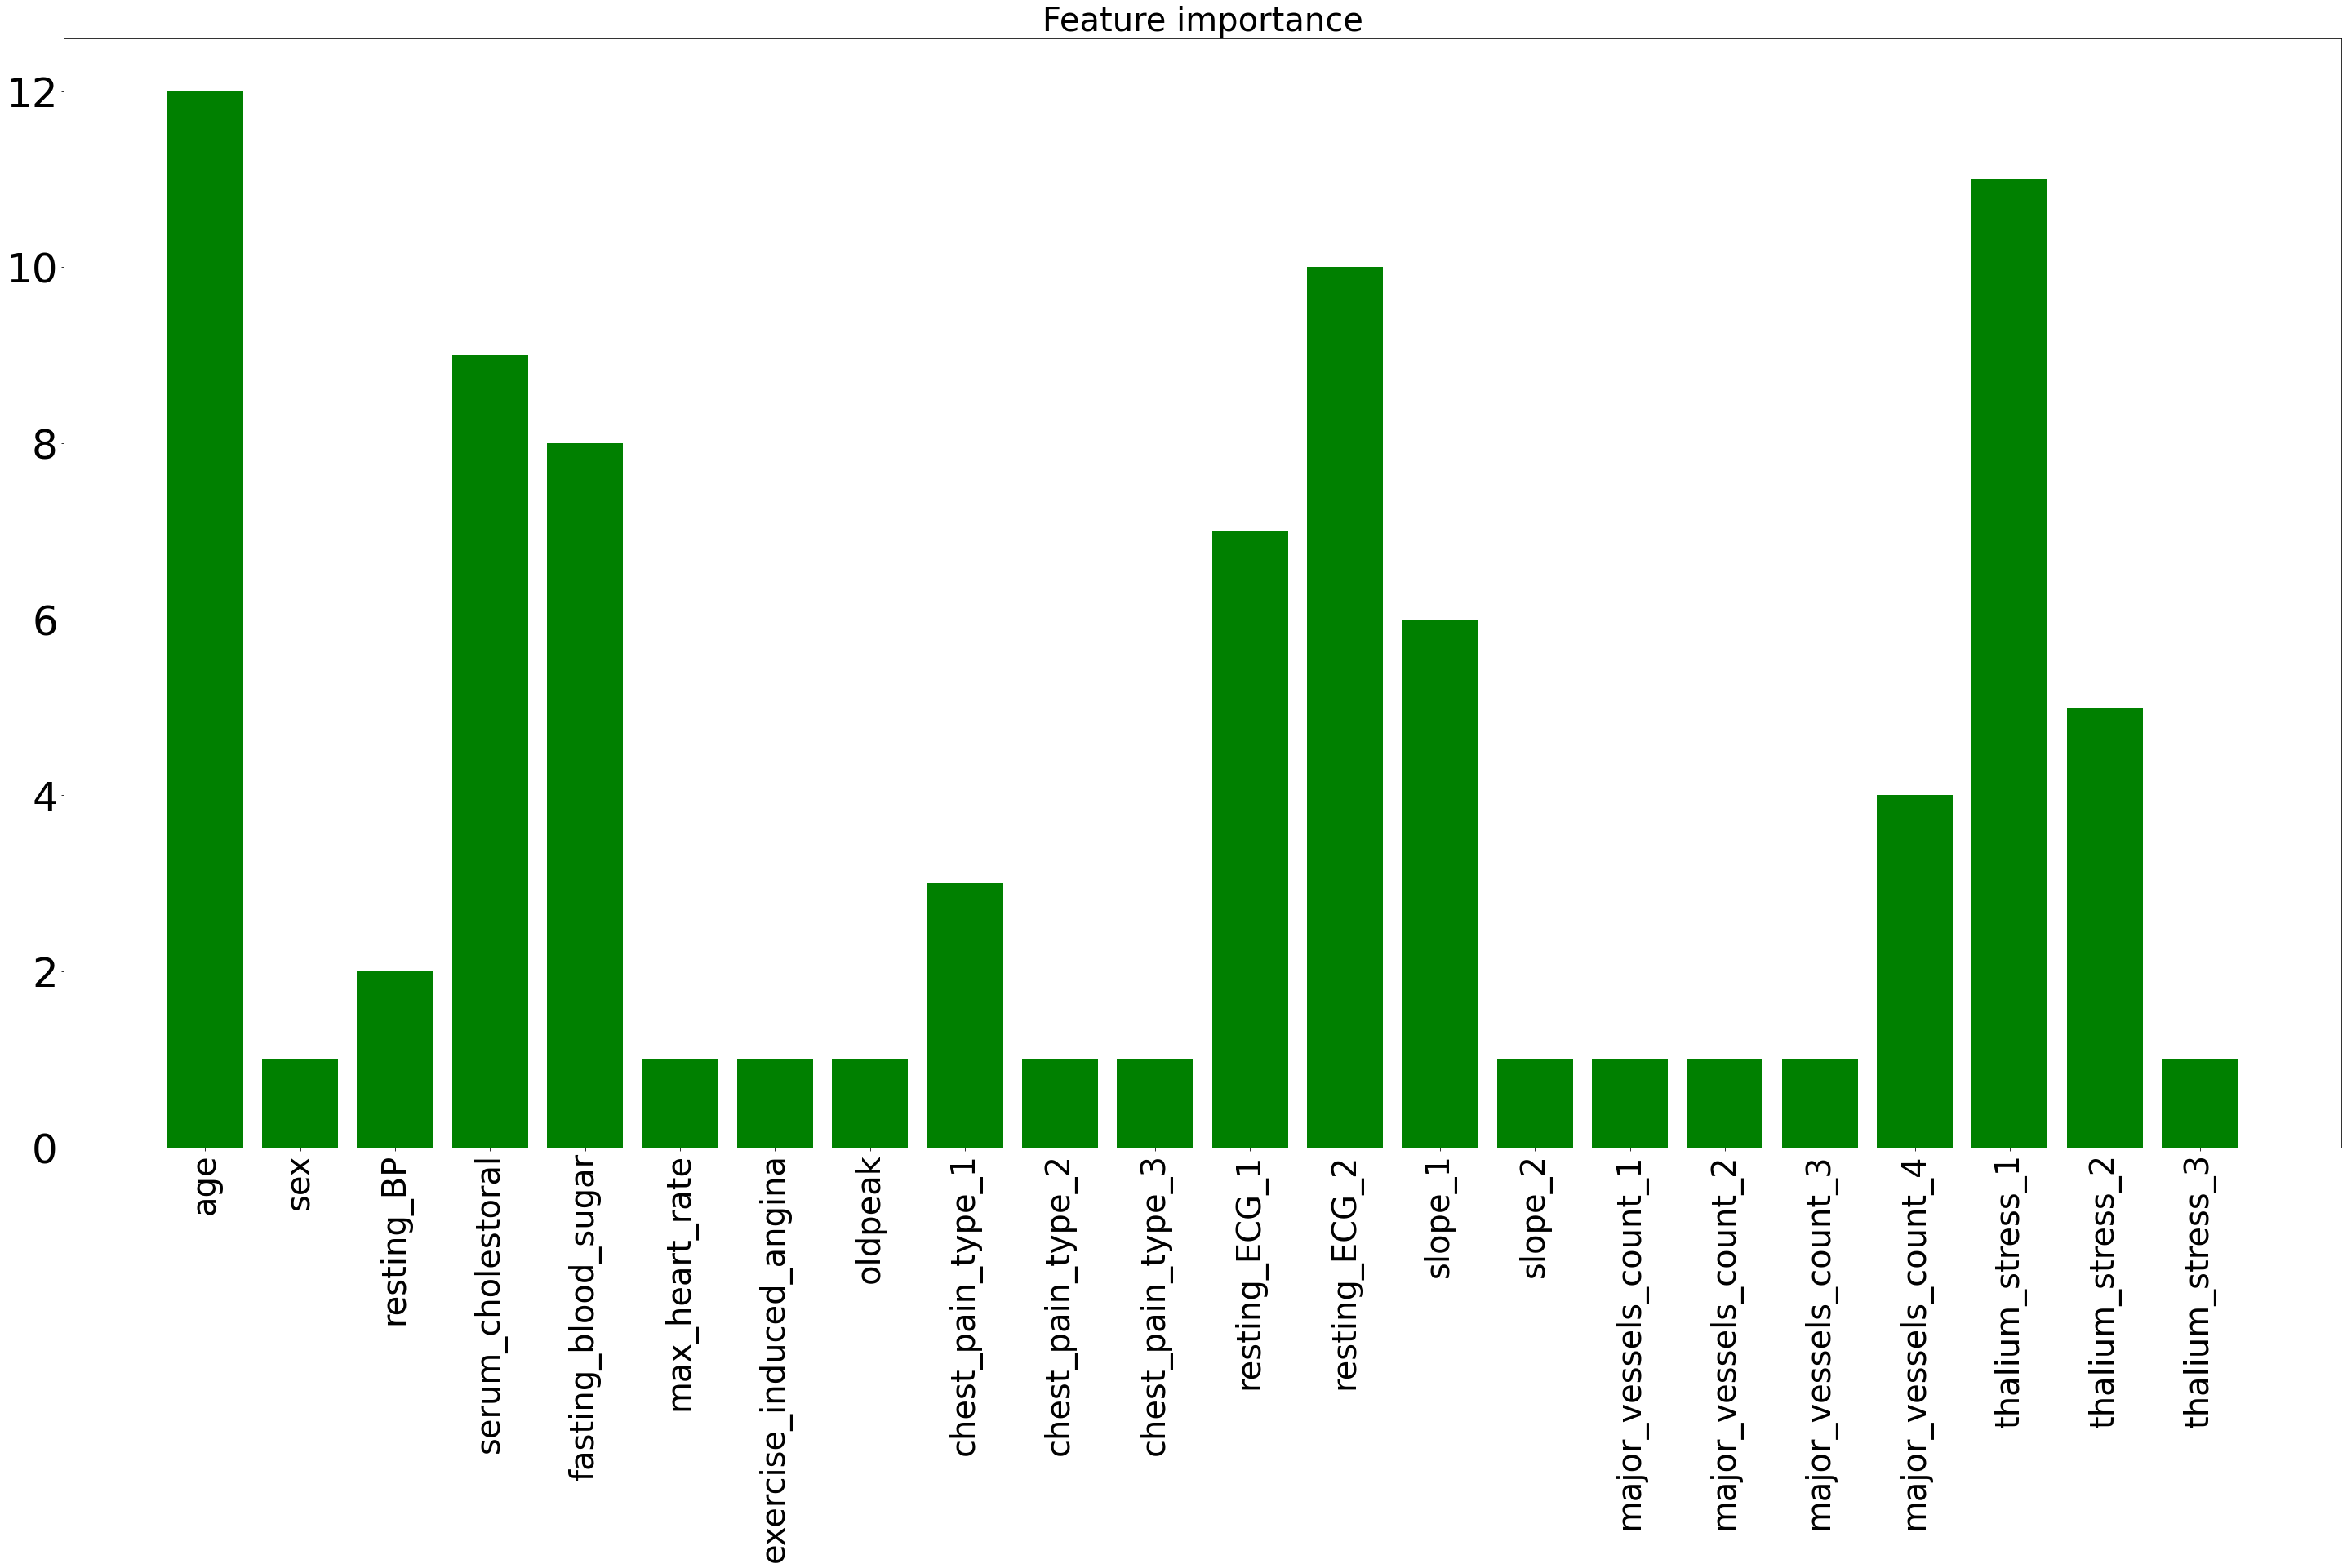

In [54]:
params = {'axes.labelsize': 280,'axes.titlesize':40, 'legend.fontsize': 18, 'xtick.labelsize': 40, 'ytick.labelsize': 50}
plt.figure(figsize=(50,25))
plt.rcParams.update(params)
ax = plt.bar(range(X_train.shape[1]), rfe_logit_ranks, color='green', align = 'center')
ax = plt.title('Feature importance')
ax = plt.xticks(range(X_train.shape[1]), X_train.columns, rotation=90)
plt.show()

In [55]:
feature_idx2 = rfe_logit.support_
feature_names2 = X_train.columns[feature_idx2]
feature_names2

Index(['sex', 'max_heart_rate', 'exercise_induced_angina', 'oldpeak',
       'chest_pain_type_2', 'chest_pain_type_3', 'slope_2',
       'major_vessels_count_1', 'major_vessels_count_2',
       'major_vessels_count_3', 'thalium_stress_3'],
      dtype='object')

#### SelectFromModel - This is a meta transformer for selecting features based on importance

In [56]:
xgb = XGBClassifier()
select_xg = SelectFromModel(estimator=xgb, threshold='median')
select_xg

SelectFromModel(estimator=XGBClassifier(base_score=None, booster=None,
                                        colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=None, gamma=None,
                                        gpu_id=None, importance_type='gain',
                                        interaction_constraints=None,
                                        learning_rate=None, max_delta_step=None,
                                        max_depth=None, min_child_weight=None,
                                        missing=nan, monotone_constraints=None,
                                        n_estimators=100, n_jobs=None,
                                        num_parallel_tree=None,
                                        random_state=None, reg_alpha=None,
                                        reg_lambda=None, scale_pos_weight=None,
                                        subsample=

In [57]:
select_xg.fit_transform(X_train, Y_train)

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [1.        , 1.        , 0.12903226, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.        , 0.58064516, ..., 0.        , 0.        ,
        1.        ],
       ...,
       [1.        , 0.        , 0.01612903, ..., 0.        , 0.        ,
        1.        ],
       [1.        , 0.        , 0.12903226, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [58]:
feature_idx3 = select_xg.get_support()
feature_names3 = X_train.columns[feature_idx3]
feature_names3

Index(['sex', 'exercise_induced_angina', 'oldpeak', 'chest_pain_type_2',
       'chest_pain_type_3', 'slope_1', 'major_vessels_count_1',
       'major_vessels_count_2', 'major_vessels_count_3', 'thalium_stress_1',
       'thalium_stress_2'],
      dtype='object')

### Final Selected features

We have 4 set of features now

- Default features without any feature selection
- Features selected from RFECV(Random Forest)
- Features selected from RFECV(Logistic)
- Features selected from meta transformer

Lets start with Modeling now, I will train algorithms on all of these feature sets and see which are the best ones.

### Predictive Modeling & Hyperparameter Tuning
I will train below Machine Learning algorithms to build models for classifying Heart Disease (binary classification) using the above 3 set of selected features.

- Logistic Regression
- Support Vector Machine
- K-Nearest Neighbours
- Random Forest Classifier
- XGBoost Classifier

I will use Grid Search and CV to find the best Hyperparameters for each algorithm.

In [59]:
X_train_2 = X_train[feature_names]
X_train_3 = X_train[feature_names2]
X_train_4 = X_train[feature_names3]

X_test_2 = X_test[feature_names]
X_test_3 = X_test[feature_names2]
X_test_4 = X_test[feature_names3]

In [60]:
len(X_train.columns), len(X_train_2.columns), len(X_train_3.columns), len(X_train_4.columns)


(22, 17, 11, 11)

### Baseline Classifiers

Let's quickly run some baseline Classification without any Tuning and using all the extracted features. After this I will use Grid Search and Cross-Validation to tune the Hyperparameters for all 5 algorithms

In [61]:
logit_clf = LogisticRegression()
logit_clf.fit(X_train, Y_train)

y_pred = logit_clf.predict(X_test)
print('Accuracy Score: ', str(accuracy_score(Y_test, y_pred)))
print('Classification Report: ')
print(classification_report(Y_test, y_pred))

Accuracy Score:  0.8852459016393442
Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.93      0.89        29
           1       0.93      0.84      0.89        32

    accuracy                           0.89        61
   macro avg       0.89      0.89      0.89        61
weighted avg       0.89      0.89      0.89        61



In [62]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, Y_train)

y_pred = knn_clf.predict(X_test)
print('Accuracy Score: ', str(accuracy_score(Y_test, y_pred)))
print('Classification Report: ')
print(classification_report(Y_test, y_pred))

Accuracy Score:  0.8524590163934426
Classification Report: 
              precision    recall  f1-score   support

           0       0.81      0.90      0.85        29
           1       0.90      0.81      0.85        32

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.86      0.85      0.85        61



In [63]:
svm_clf = SVC(kernel='rbf', gamma=0.1, C=1.0)
svm_clf.fit(X_train, Y_train)

y_pred = svm_clf.predict(X_test)
print('Accuracy Score: ', str(accuracy_score(Y_test, y_pred)))
print('Classification Report: ')
print(classification_report(Y_test, y_pred))

Accuracy Score:  0.8524590163934426
Classification Report: 
              precision    recall  f1-score   support

           0       0.81      0.90      0.85        29
           1       0.90      0.81      0.85        32

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.86      0.85      0.85        61



In [64]:
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, Y_train)

y_pred = dt_clf.predict(X_test)
print('Accuracy Score: ', str(accuracy_score(Y_test, y_pred)))
print('Classification Report: ')
print(classification_report(Y_test, y_pred))

Accuracy Score:  0.7377049180327869
Classification Report: 
              precision    recall  f1-score   support

           0       0.70      0.79      0.74        29
           1       0.79      0.69      0.73        32

    accuracy                           0.74        61
   macro avg       0.74      0.74      0.74        61
weighted avg       0.74      0.74      0.74        61



### Grid Search & Hyperparameter Tuning

In [65]:
def fit_model(X_train, Y_train, X_test, Y_test, classifier_name, classifier, gridSearchParam, cv, save_model=False):
    #setting the seed for reproducability
    #np.random.seed(100)
    print('Training {} algorithm.........'.format(classifier_name))
    grid_clf = GridSearchCV(estimator=classifier,
                            param_grid=gridSearchParam, 
                            cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_res = grid_clf.fit(X_train, Y_train)
    best_params = grid_res.best_params_
    Y_pred = grid_res.predict(X_test)
    cm = confusion_matrix(Y_test, Y_pred)
    
    
    print(Y_pred)
    print("=====================================================================")
    print('Training Accuracy Score: ' + str(accuracy_score(Y_train, grid_res.predict(X_train))))
    print("---------------------------------------------------------------------")
    print('Test Accuracy Score: ' + str(accuracy_score(Y_test, Y_pred)))
    print("---------------------------------------------------------------------")
    print('Best HyperParameters: ', best_params)
    print("---------------------------------------------------------------------")
    print('Classification Report: ')
    print(classification_report(Y_test, Y_pred))
    print("---------------------------------------------------------------------")
    
    #fig, ax = plt.subplots(figsize=(7,7))
    ax= plt.subplot()
    #plt.figure(figsize=(6,6))
    sns.set(font_scale=1.0) # Adjust to fit
    label_font = {'size':'5'}
    plt.rcParams.update({'font.size': 14})
    sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels') 
    ax.set_title('Confusion Matrix') 
    ax.xaxis.set_ticklabels(['No Heart Disease', 'Heart Disease'])
    ax.yaxis.set_ticklabels(['No Heart Disease', 'Heart Disease'])
    print("=====================================================================")
    
    if save_model:
        file_name = classifier_name + '.pkl'
        pickle.dump(grid_res, open(file_name, 'wb'))
        #joblib.dump(grid_res, file_name)
        print('Model is saved successfully!')

### Logistic Regression

In [66]:
cv = 5 
hyper_params = {'C': [0.0001, 0.001, 0.1, 1, 10, 20],   #np.logspace(0, 4, 10),
               'penalty': ['l1','l2'],
               'solver': ['liblinear', 'saga']}

Training Logistic Regression algorithm.........
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.6s finished


[0 1 1 0 1 1 1 0 0 0 0 0 1 0 1 1 1 0 0 0 1 0 0 1 1 1 1 1 0 1 0 0 0 0 1 0 1
 1 1 1 1 1 1 1 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0]
Training Accuracy Score: 0.8677685950413223
---------------------------------------------------------------------
Test Accuracy Score: 0.8688524590163934
---------------------------------------------------------------------
Best HyperParameters:  {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
---------------------------------------------------------------------
Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.90      0.87        29
           1       0.90      0.84      0.87        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61

---------------------------------------------------------------------


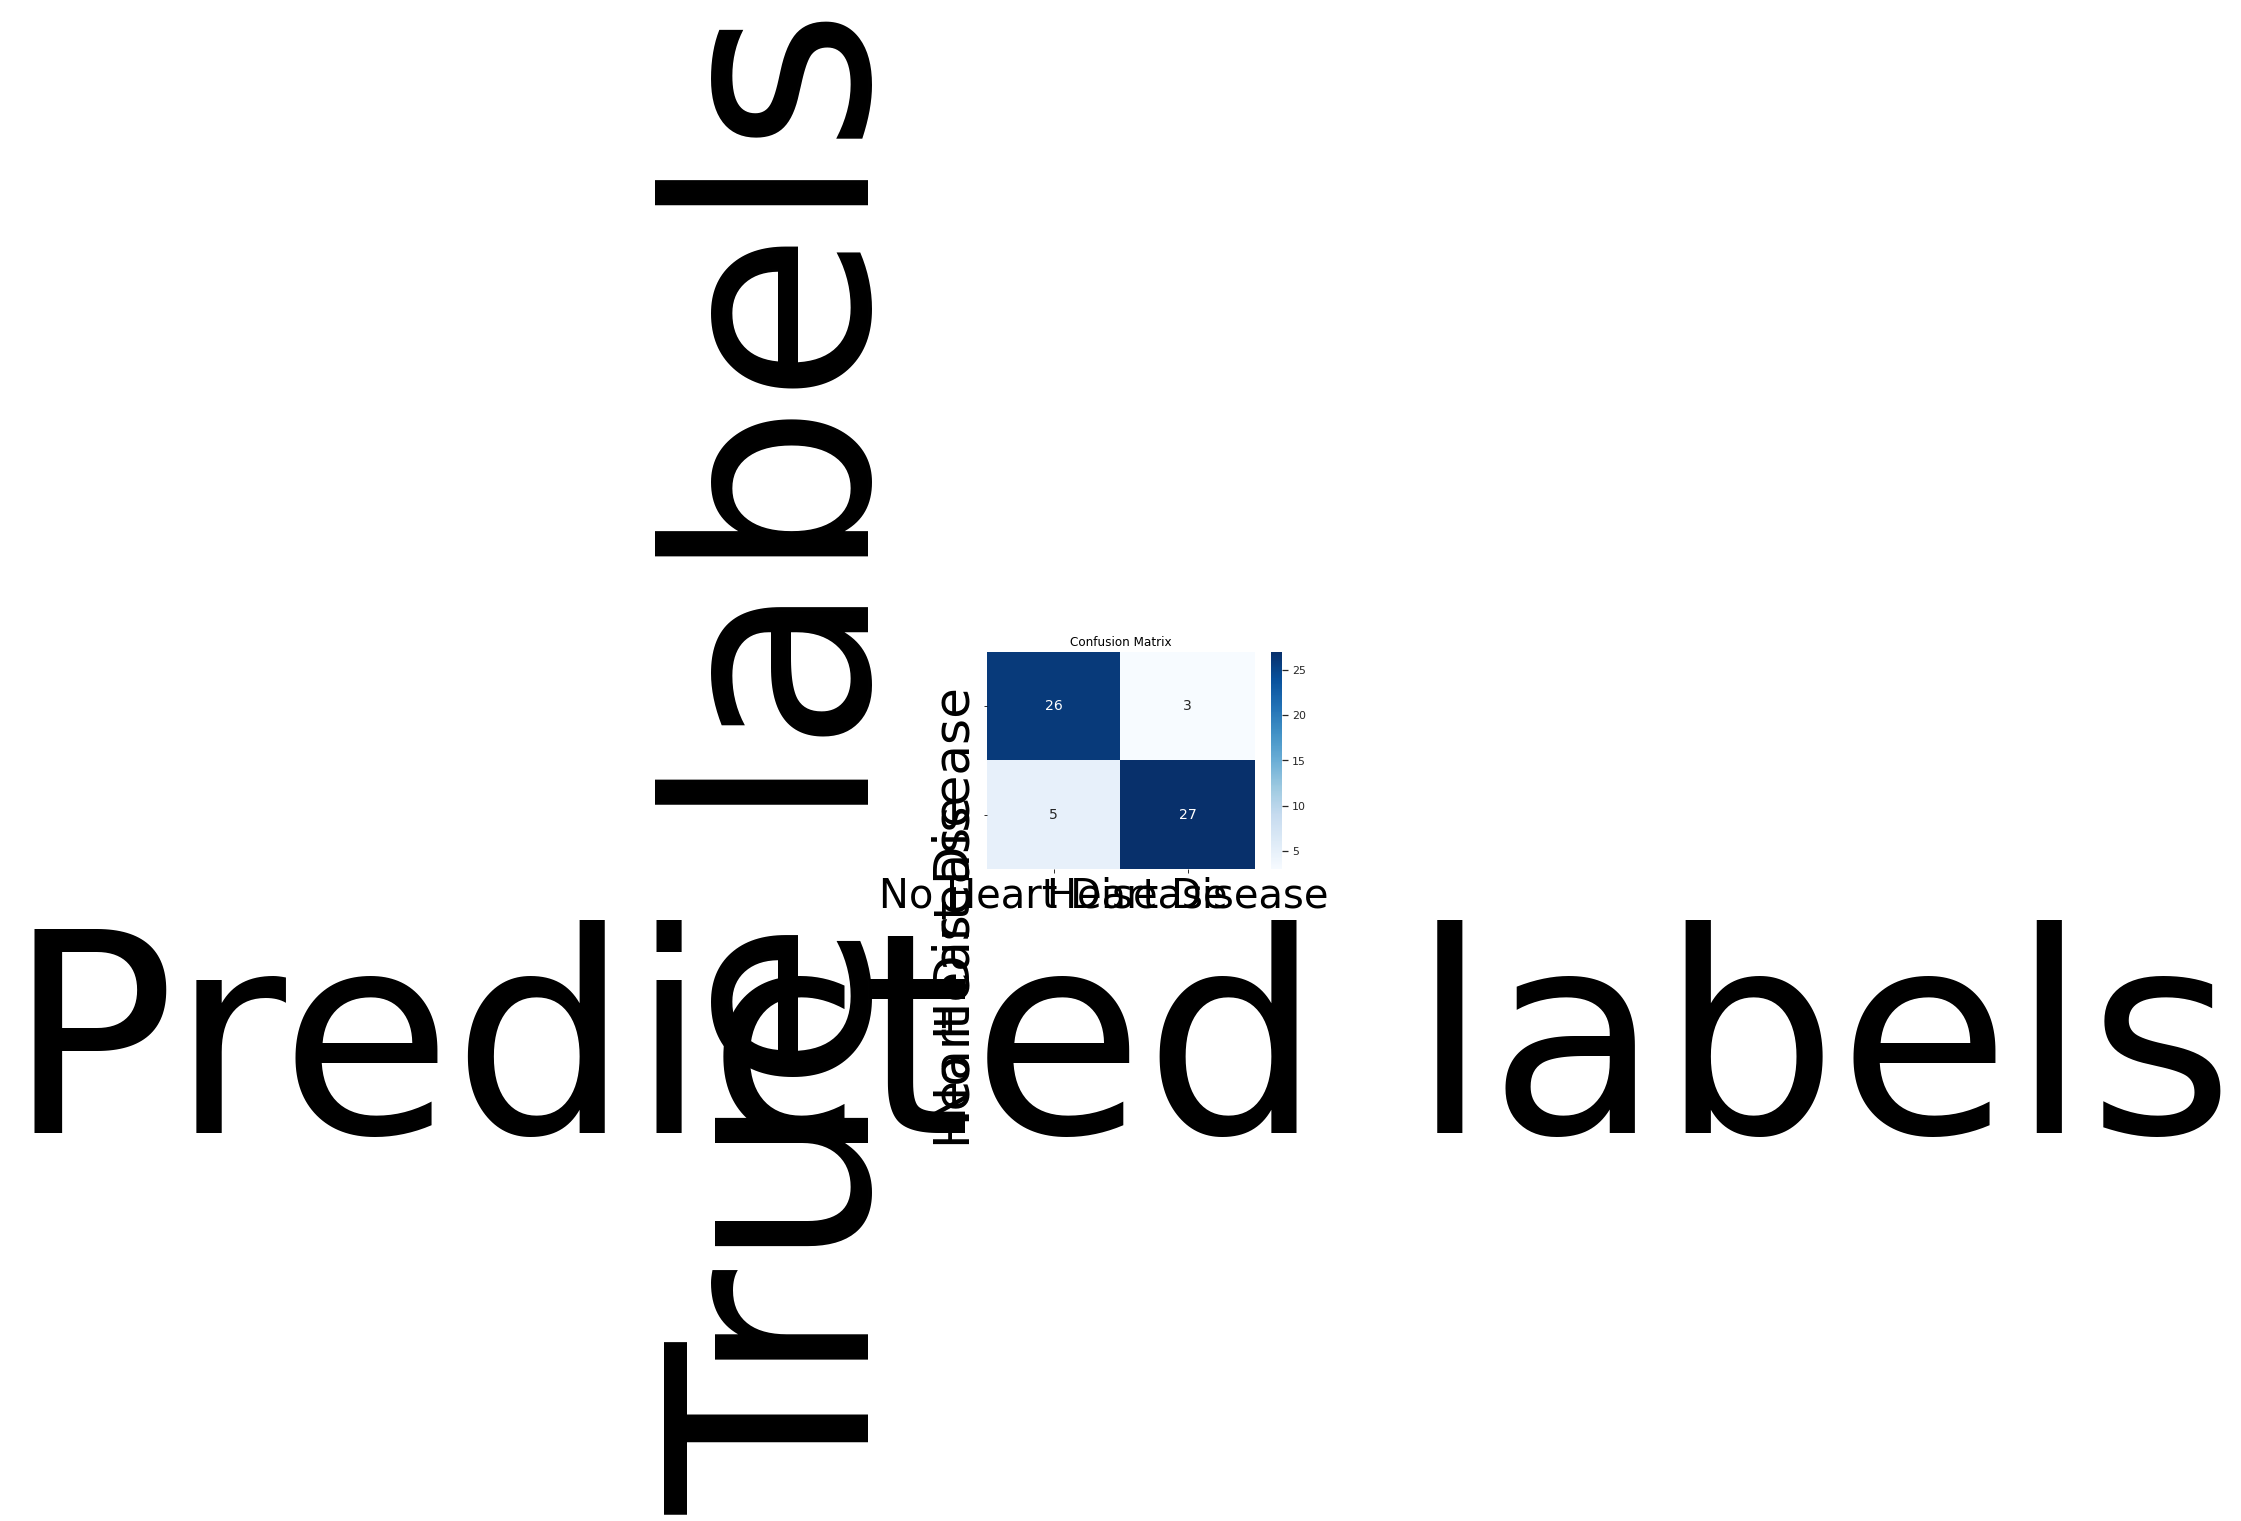

In [67]:
#Feature Set 1 
fit_model(X_train, Y_train, X_test, Y_test, 'Logistic Regression', LogisticRegression(), hyper_params, cv)

Training Logistic Regression algorithm.........
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.9s finished


[0 1 1 0 1 1 1 0 0 0 1 0 1 0 1 1 1 0 0 0 1 0 0 1 1 1 1 1 0 1 0 0 0 0 1 0 1
 1 1 1 1 1 1 1 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0]
Training Accuracy Score: 0.8636363636363636
---------------------------------------------------------------------
Test Accuracy Score: 0.8852459016393442
---------------------------------------------------------------------
Best HyperParameters:  {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
---------------------------------------------------------------------
Classification Report: 
              precision    recall  f1-score   support

           0       0.87      0.90      0.88        29
           1       0.90      0.88      0.89        32

    accuracy                           0.89        61
   macro avg       0.88      0.89      0.89        61
weighted avg       0.89      0.89      0.89        61

---------------------------------------------------------------------


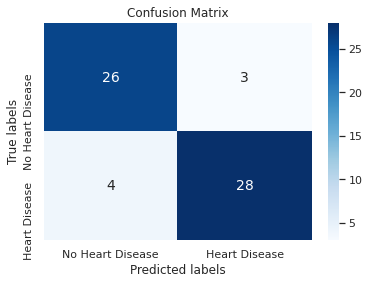

In [68]:
#Feature Set 2 
fit_model(X_train_2, Y_train, X_test_2, Y_test, 'Logistic Regression', LogisticRegression(), hyper_params, cv)

Training Logistic Regression algorithm.........
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.8s finished


[0 1 1 0 1 1 1 0 0 0 1 0 1 0 1 1 1 0 0 0 1 0 0 1 1 1 1 1 0 1 0 0 0 0 1 0 1
 1 1 1 1 1 1 1 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0]
Training Accuracy Score: 0.8636363636363636
---------------------------------------------------------------------
Test Accuracy Score: 0.8852459016393442
---------------------------------------------------------------------
Best HyperParameters:  {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
---------------------------------------------------------------------
Classification Report: 
              precision    recall  f1-score   support

           0       0.87      0.90      0.88        29
           1       0.90      0.88      0.89        32

    accuracy                           0.89        61
   macro avg       0.88      0.89      0.89        61
weighted avg       0.89      0.89      0.89        61

---------------------------------------------------------------------


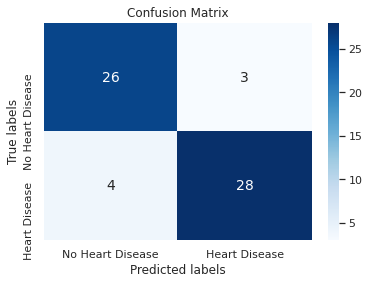

In [69]:
#Feature Set 3 
fit_model(X_train_3, Y_train, X_test_3, Y_test, 'Logistic Regression', LogisticRegression(), hyper_params, cv)

Training Logistic Regression algorithm.........
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.0s finished


[0 1 1 0 1 1 1 0 0 1 1 1 1 0 1 1 1 0 0 0 1 0 1 1 1 1 1 1 0 1 0 0 0 0 1 0 1
 1 1 1 1 1 1 1 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0]
Training Accuracy Score: 0.871900826446281
---------------------------------------------------------------------
Test Accuracy Score: 0.9016393442622951
---------------------------------------------------------------------
Best HyperParameters:  {'C': 20, 'penalty': 'l2', 'solver': 'saga'}
---------------------------------------------------------------------
Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.86      0.89        29
           1       0.88      0.94      0.91        32

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61

---------------------------------------------------------------------


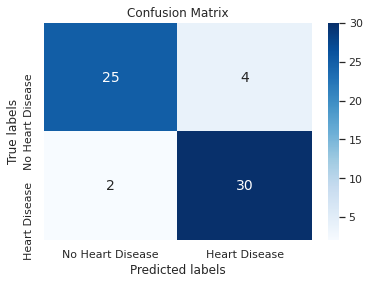

In [70]:
#Feature Set 4 
fit_model(X_train_4, Y_train, X_test_4, Y_test, 'Logistic Regression', LogisticRegression(), hyper_params, cv)

### Support Vector Machine

In [71]:
cv = 5 
hyper_params = {'C': [0.01, 0.1, 1, 10, 100, 1000],
                'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.1, 1, 3],
                'kernel': ['linear', 'rbf']}

Training SVM Classifier algorithm.........
Fitting 5 folds for each of 84 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:    8.2s finished


[0 1 1 0 1 1 1 0 0 1 0 0 1 0 1 1 1 0 0 0 1 0 1 1 1 1 1 1 0 1 0 0 0 0 1 0 1
 1 1 1 1 1 1 1 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0]
Training Accuracy Score: 0.859504132231405
---------------------------------------------------------------------
Test Accuracy Score: 0.8688524590163934
---------------------------------------------------------------------
Best HyperParameters:  {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
---------------------------------------------------------------------
Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        29
           1       0.88      0.88      0.88        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61

---------------------------------------------------------------------


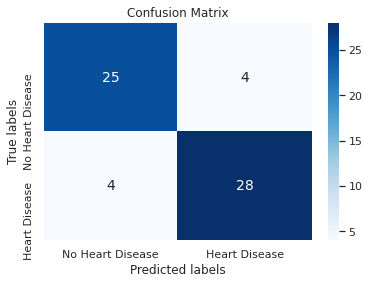

In [72]:
#Feature Set 1 
fit_model(X_train, Y_train, X_test, Y_test, 'SVM Classifier', SVC(), hyper_params, cv)

Training SVM Classifier algorithm.........
Fitting 5 folds for each of 84 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:    7.9s finished


[0 1 1 0 1 1 1 0 0 0 1 0 1 0 1 1 1 0 0 0 1 0 0 1 1 1 1 1 0 1 0 0 0 0 1 0 1
 1 1 1 1 1 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0]
Training Accuracy Score: 0.9008264462809917
---------------------------------------------------------------------
Test Accuracy Score: 0.8688524590163934
---------------------------------------------------------------------
Best HyperParameters:  {'C': 1000, 'gamma': 0.005, 'kernel': 'rbf'}
---------------------------------------------------------------------
Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.90      0.87        29
           1       0.90      0.84      0.87        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61

---------------------------------------------------------------------


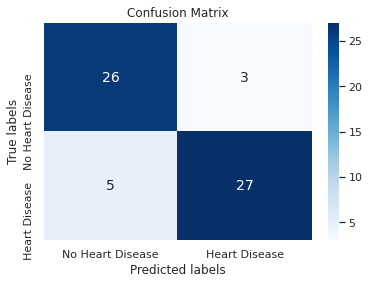

In [73]:
#Feature Set 2
fit_model(X_train_2, Y_train, X_test_2, Y_test, 'SVM Classifier', SVC(), hyper_params, cv)

Training SVM Classifier algorithm.........
Fitting 5 folds for each of 84 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:    3.6s finished


[0 1 1 0 1 1 1 0 0 1 1 0 1 0 1 1 1 0 0 0 1 0 0 1 1 1 1 1 0 1 0 0 0 0 1 0 1
 1 1 1 1 1 1 1 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0]
Training Accuracy Score: 0.859504132231405
---------------------------------------------------------------------
Test Accuracy Score: 0.9016393442622951
---------------------------------------------------------------------
Best HyperParameters:  {'C': 100, 'gamma': 0.0001, 'kernel': 'linear'}
---------------------------------------------------------------------
Classification Report: 
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        29
           1       0.91      0.91      0.91        32

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61

---------------------------------------------------------------------


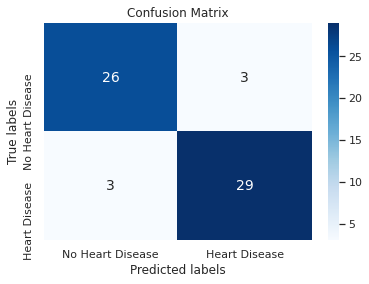

In [74]:
#Feature Set 3
fit_model(X_train_3, Y_train, X_test_3, Y_test, 'SVM Classifier', SVC(), hyper_params, cv)


Training SVM Classifier algorithm.........
Fitting 5 folds for each of 84 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 394 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 417 out of 420 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:    4.0s finished


[0 1 1 0 1 1 1 0 0 1 1 1 1 0 1 1 1 0 0 0 1 0 1 1 1 1 1 1 0 1 0 0 0 0 1 0 1
 1 1 1 1 1 1 1 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0]
Training Accuracy Score: 0.8884297520661157
---------------------------------------------------------------------
Test Accuracy Score: 0.9016393442622951
---------------------------------------------------------------------
Best HyperParameters:  {'C': 1000, 'gamma': 0.005, 'kernel': 'rbf'}
---------------------------------------------------------------------
Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.86      0.89        29
           1       0.88      0.94      0.91        32

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61

---------------------------------------------------------------------


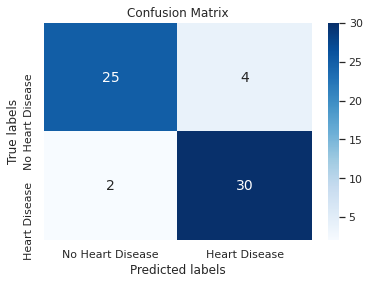

In [75]:
#Feature Set 4
fit_model(X_train_4, Y_train, X_test_4, Y_test, 'SVM Classifier', SVC(), hyper_params, cv)

### K-Nearest Neighbours

In [76]:
cv = 5 
hyper_params = {'n_neighbors': list(range(1,20)),
                'leaf_size': list(range(1,15)),
                'p': [1,2]}

Training KNN Classifier algorithm.........
Fitting 5 folds for each of 532 candidates, totalling 2660 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1500 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 2660 out of 2660 | elapsed:   22.5s finished


[0 0 1 0 1 1 1 0 0 1 0 0 1 0 1 1 1 0 0 0 0 0 1 1 1 0 1 1 0 1 0 0 0 0 1 0 1
 1 0 1 1 1 1 1 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0]
Training Accuracy Score: 0.8099173553719008
---------------------------------------------------------------------
Test Accuracy Score: 0.8688524590163934
---------------------------------------------------------------------
Best HyperParameters:  {'leaf_size': 1, 'n_neighbors': 14, 'p': 1}
---------------------------------------------------------------------
Classification Report: 
              precision    recall  f1-score   support

           0       0.82      0.93      0.87        29
           1       0.93      0.81      0.87        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.88      0.87      0.87        61

---------------------------------------------------------------------


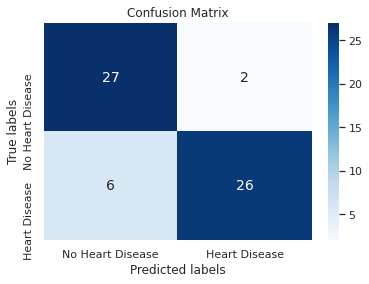

In [77]:
#Feature Set 1 
fit_model(X_train, Y_train, X_test, Y_test, 'KNN Classifier', KNeighborsClassifier(), hyper_params, cv)

Training KNN Classifier algorithm.........
Fitting 5 folds for each of 532 candidates, totalling 2660 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 1472 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 2657 out of 2660 | elapsed:   21.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 2660 out of 2660 | elapsed:   22.0s finished


[0 0 1 0 1 1 1 0 0 1 1 0 1 0 1 1 1 0 0 0 0 0 1 1 1 1 1 1 0 1 0 0 0 0 1 0 1
 1 0 1 1 1 1 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0]
Training Accuracy Score: 0.8471074380165289
---------------------------------------------------------------------
Test Accuracy Score: 0.8360655737704918
---------------------------------------------------------------------
Best HyperParameters:  {'leaf_size': 1, 'n_neighbors': 8, 'p': 1}
---------------------------------------------------------------------
Classification Report: 
              precision    recall  f1-score   support

           0       0.79      0.90      0.84        29
           1       0.89      0.78      0.83        32

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61

---------------------------------------------------------------------


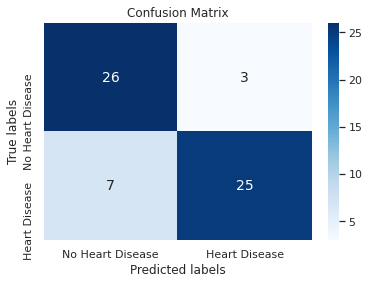

In [78]:
#Feature Set 2
fit_model(X_train_2, Y_train, X_test_2, Y_test, 'KNN Classifier', KNeighborsClassifier(), hyper_params, cv)

Training KNN Classifier algorithm.........
Fitting 5 folds for each of 532 candidates, totalling 2660 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 1500 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 2660 out of 2660 | elapsed:   21.0s finished


[0 0 0 0 1 1 1 0 0 0 1 0 1 0 1 1 1 0 0 0 1 0 1 1 1 1 1 1 0 1 0 0 0 0 1 0 1
 1 0 1 1 1 1 1 1 0 1 1 0 0 0 0 1 1 0 0 0 1 0 0 0]
Training Accuracy Score: 0.8471074380165289
---------------------------------------------------------------------
Test Accuracy Score: 0.8360655737704918
---------------------------------------------------------------------
Best HyperParameters:  {'leaf_size': 1, 'n_neighbors': 12, 'p': 1}
---------------------------------------------------------------------
Classification Report: 
              precision    recall  f1-score   support

           0       0.81      0.86      0.83        29
           1       0.87      0.81      0.84        32

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61

---------------------------------------------------------------------


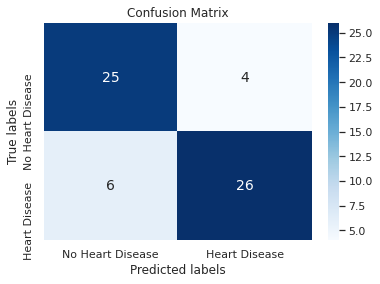

In [79]:
#Feature Set 3 
fit_model(X_train_3, Y_train, X_test_3, Y_test, 'KNN Classifier', KNeighborsClassifier(), hyper_params, cv)

Training KNN Classifier algorithm.........
Fitting 5 folds for each of 532 candidates, totalling 2660 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 540 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 2660 out of 2660 | elapsed:   19.5s finished


[0 1 0 0 1 1 0 0 0 1 0 0 1 0 1 1 1 0 0 0 1 0 1 0 1 1 1 1 0 1 0 0 0 0 1 0 0
 1 0 1 1 1 1 0 1 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0]
Training Accuracy Score: 0.859504132231405
---------------------------------------------------------------------
Test Accuracy Score: 0.7377049180327869
---------------------------------------------------------------------
Best HyperParameters:  {'leaf_size': 4, 'n_neighbors': 6, 'p': 1}
---------------------------------------------------------------------
Classification Report: 
              precision    recall  f1-score   support

           0       0.69      0.83      0.75        29
           1       0.81      0.66      0.72        32

    accuracy                           0.74        61
   macro avg       0.75      0.74      0.74        61
weighted avg       0.75      0.74      0.74        61

---------------------------------------------------------------------


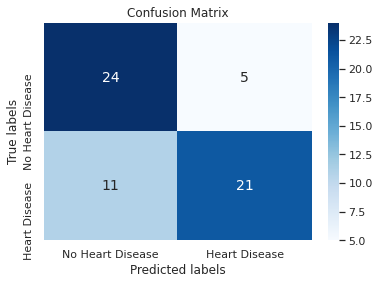

In [80]:
#Feature Set 4
fit_model(X_train_4, Y_train, X_test_4, Y_test, 'KNN Classifier', KNeighborsClassifier(), hyper_params, cv)

### Random Forest Classifer

In [81]:
cv = 5 
hyper_params = {'n_estimators': [10, 50, 100, 200, 500],
                'max_depth': [2, 4, 6, 10, 15, 20, 30],
                'min_samples_split': [2, 5, 10, 20],
                'min_samples_leaf': [1, 2, 5, 10]}

Training Random Forest algorithm.........
Fitting 5 folds for each of 560 candidates, totalling 2800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:   55.5s
[Parallel(n_jobs=-1)]: Done 460 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 810 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 1260 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 1810 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 2460 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 2800 out of 2800 | elapsed: 12.2min finished


[0 0 1 0 1 1 1 0 0 1 1 0 1 0 1 1 1 0 0 0 0 0 1 1 1 1 1 1 0 1 0 0 0 0 1 0 1
 1 1 1 1 1 1 1 1 0 0 1 0 0 1 0 0 1 1 0 0 1 0 0 0]
Training Accuracy Score: 0.8553719008264463
---------------------------------------------------------------------
Test Accuracy Score: 0.8360655737704918
---------------------------------------------------------------------
Best HyperParameters:  {'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 10}
---------------------------------------------------------------------
Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.83      0.83        29
           1       0.84      0.84      0.84        32

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61

---------------------------------------------------------------------


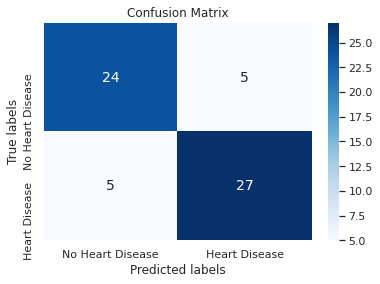

In [82]:
#Feature Set 1 
fit_model(X_train, Y_train, X_test, Y_test, 'Random Forest', RandomForestClassifier(), hyper_params, cv)

Training Random Forest algorithm.........
Fitting 5 folds for each of 560 candidates, totalling 2800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:   51.3s
[Parallel(n_jobs=-1)]: Done 460 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 810 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1260 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 1810 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 2460 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 2800 out of 2800 | elapsed: 11.9min finished


[0 0 1 0 1 1 1 0 0 1 1 0 1 0 1 1 1 0 0 0 1 0 0 1 1 1 1 1 0 1 0 0 0 0 0 0 0
 1 0 1 1 1 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0]
Training Accuracy Score: 0.9214876033057852
---------------------------------------------------------------------
Test Accuracy Score: 0.8524590163934426
---------------------------------------------------------------------
Best HyperParameters:  {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
---------------------------------------------------------------------
Classification Report: 
              precision    recall  f1-score   support

           0       0.79      0.93      0.86        29
           1       0.93      0.78      0.85        32

    accuracy                           0.85        61
   macro avg       0.86      0.86      0.85        61
weighted avg       0.86      0.85      0.85        61

---------------------------------------------------------------------


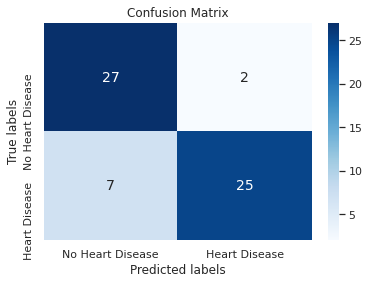

In [83]:
#Feature Set 2
fit_model(X_train_2, Y_train, X_test_2, Y_test, 'Random Forest', RandomForestClassifier(), hyper_params, cv)

Training Random Forest algorithm.........
Fitting 5 folds for each of 560 candidates, totalling 2800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done 460 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 810 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 1260 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1810 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 2460 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 2800 out of 2800 | elapsed: 11.7min finished


[0 1 1 0 1 1 0 0 0 1 1 0 1 0 1 1 1 0 0 0 0 0 1 1 1 1 1 1 0 1 0 0 0 0 1 0 0
 1 0 1 1 1 1 0 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0]
Training Accuracy Score: 0.9214876033057852
---------------------------------------------------------------------
Test Accuracy Score: 0.8032786885245902
---------------------------------------------------------------------
Best HyperParameters:  {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10}
---------------------------------------------------------------------
Classification Report: 
              precision    recall  f1-score   support

           0       0.76      0.86      0.81        29
           1       0.86      0.75      0.80        32

    accuracy                           0.80        61
   macro avg       0.81      0.81      0.80        61
weighted avg       0.81      0.80      0.80        61

---------------------------------------------------------------------


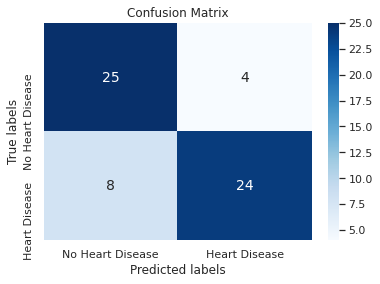

In [84]:
#Feature Set 3 
fit_model(X_train_3, Y_train, X_test_3, Y_test, 'Random Forest', RandomForestClassifier(), hyper_params, cv)

### Best Model & features
Logistic Regression with feature set 4 , SVM with feature set 4 & KNN with feature set 1 are the best models with 90.16% Test accuracy and 90% f1 score

Based on the analysis and looking at all aspects of Training accuracy, Testing Accuracy, Precision & Recall, these 3 are our best estimator

### Best features -

['sex', 'max_heart_rate', 'exercise_induced_angina', 'oldpeak', 'chest_pain_type_2',
       'chest_pain_type_3', 'slope_1', 'major_vessels_count_1',
       'major_vessels_count_2',
       'thalium_stress_2']

### Save Best Model for Inference Pipeline

In [85]:
import pickle


Training SVMClassifier algorithm.........
Fitting 5 folds for each of 84 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[0 1 1 0 1 1 1 0 0 1 1 1 1 0 1 1 1 0 0 0 1 0 1 1 1 1 1 1 0 1 0 0 0 0 1 0 1
 1 1 1 1 1 1 1 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0]
Training Accuracy Score: 0.8884297520661157
---------------------------------------------------------------------
Test Accuracy Score: 0.9016393442622951
---------------------------------------------------------------------
Best HyperParameters:  {'C': 1000, 'gamma': 0.005, 'kernel': 'rbf'}
---------------------------------------------------------------------
Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.86      0.89        29
           1       0.88      0.94      0.91        32

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61

---------------------------------------------------------------------
Model is saved successfully!


[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:    3.4s finished


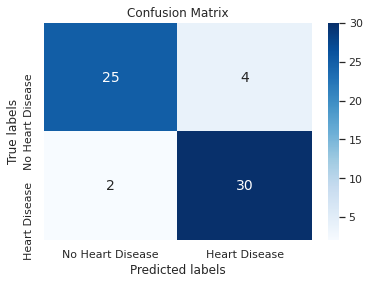

In [86]:
cv = 5 
hyper_params = {'C': [0.01, 0.1, 1, 10, 100, 1000],
                'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.1, 1, 3],
                'kernel': ['linear', 'rbf']}


#Saving SVM Best Model using feature Set 4
fit_model(X_train_4, Y_train, X_test_4, Y_test, 'SVMClassifier', SVC(), hyper_params, cv, save_model=True)

Training KNN Classifier algorithm.........
Fitting 5 folds for each of 532 candidates, totalling 2660 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 1484 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 2660 out of 2660 | elapsed:   18.4s finished


[0 0 1 0 1 1 1 0 0 1 0 0 1 0 1 1 1 0 0 0 0 0 1 1 1 0 1 1 0 1 0 0 0 0 1 0 1
 1 0 1 1 1 1 1 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0]
Training Accuracy Score: 0.8099173553719008
---------------------------------------------------------------------
Test Accuracy Score: 0.8688524590163934
---------------------------------------------------------------------
Best HyperParameters:  {'leaf_size': 1, 'n_neighbors': 14, 'p': 1}
---------------------------------------------------------------------
Classification Report: 
              precision    recall  f1-score   support

           0       0.82      0.93      0.87        29
           1       0.93      0.81      0.87        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.88      0.87      0.87        61

---------------------------------------------------------------------
Model is saved successfully!


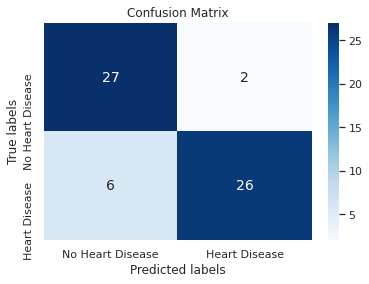

In [87]:
cv = 5 
hyper_params = {'n_neighbors': list(range(1,20)),
                'leaf_size': list(range(1,15)),
                'p': [1,2]}

#Saving KNN Best Model using feature Set 1
fit_model(X_train, Y_train, X_test, Y_test, 'KNN Classifier', KNeighborsClassifier(), hyper_params, cv, save_model=True)

Training Logistic Regression algorithm.........
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.6s finished


[0 1 1 0 1 1 1 0 0 1 1 1 1 0 1 1 1 0 0 0 1 0 1 1 1 1 1 1 0 1 0 0 0 0 1 0 1
 1 1 1 1 1 1 1 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0]
Training Accuracy Score: 0.871900826446281
---------------------------------------------------------------------
Test Accuracy Score: 0.9016393442622951
---------------------------------------------------------------------
Best HyperParameters:  {'C': 20, 'penalty': 'l2', 'solver': 'saga'}
---------------------------------------------------------------------
Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.86      0.89        29
           1       0.88      0.94      0.91        32

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61

---------------------------------------------------------------------
Model is saved successfully!


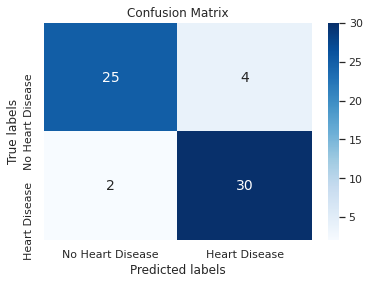

In [88]:
cv = 5 
hyper_params = {'C': [0.0001, 0.001, 0.1, 1, 10, 20],   #np.logspace(0, 4, 10),
               'penalty': ['l1','l2'],
               'solver': ['liblinear', 'saga']}

#Saving Logistic Regression Best Model using feature Set 4
fit_model(X_train_4, Y_train, X_test_4, Y_test, 'Logistic Regression', LogisticRegression(), hyper_params, cv, save_model=True)

### Ensemble Technique for Prediction of Heart Disease
We have done extensive feature selection and ran Machine learning models on 4 different set of features. After lot of Hyperparameter tuning and cross validation, I got 3 good models with f1 score of around 90% and test accuracy of around 90.16%

Now, I will create an Ensemble Max Voting of 3 best models KNN, Logistic and SVM models saved with the best hyperparameters.

***Ensemble learning will make the models more generalized and reduce the bias which a algorithm mihght have learnt***


In [89]:
svm = pickle.load(open('./SVMClassifier.pkl', 'rb'))
logit = pickle.load(open('./Logistic Regression.pkl', 'rb'))
knn = pickle.load(open('./KNN Classifier.pkl', 'rb'))

In [90]:
feature_set1 = ['age', 'sex', 'resting_BP', 'serum_cholestoral', 'fasting_blood_sugar',
       'max_heart_rate', 'exercise_induced_angina', 'oldpeak',
       'chest_pain_type_2', 'chest_pain_type_3', 'resting_ECG_1', 'slope_1',
       'slope_2', 'major_vessels_count_1', 'major_vessels_count_2',
       'thalium_stress_2', 'thalium_stress_3']

feature_set4 = ['sex', 'exercise_induced_angina', 'oldpeak', 'chest_pain_type_2',
       'chest_pain_type_3', 'slope_1', 'major_vessels_count_1',
       'major_vessels_count_2', 'major_vessels_count_3', 'thalium_stress_1',
       'thalium_stress_2']

In [91]:
pred_knn = knn.predict(X_test)
pred_logit = logit.predict(X_test_4)
pred_svm = svm.predict(X_test_4)

### Max Voting Ensemble learning 

In [92]:
import statistics


In [93]:
df_ensemble = pd.DataFrame()

In [94]:
df_ensemble['KNN'] = pred_knn
df_ensemble['Logistic'] = pred_logit
df_ensemble['SVM'] = pred_svm
df_ensemble.head(10)

,KNN,Logistic,SVM
0,0,0,0
1,0,1,1
2,1,1,1
3,0,0,0
4,1,1,1
5,1,1,1
6,1,1,1
7,0,0,0
8,0,0,0
9,1,1,1


In [95]:
def max_vote(x):
    vote = statistics.mode([int(x['KNN']), int(x['Logistic']), int(x['SVM'])])
    return vote

In [96]:
df_ensemble['Ensemble'] = df_ensemble.apply(max_vote, axis=1)
df_ensemble.head(10)

,KNN,Logistic,SVM,Ensemble
0,0,0,0,0
1,0,1,1,1
2,1,1,1,1
3,0,0,0,0
4,1,1,1,1
5,1,1,1,1
6,1,1,1,1
7,0,0,0,0
8,0,0,0,0
9,1,1,1,1


---------------------------------------------------------------------
Test Accuracy Score: 0.9016393442622951
---------------------------------------------------------------------
Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.86      0.89        29
           1       0.88      0.94      0.91        32

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61

---------------------------------------------------------------------


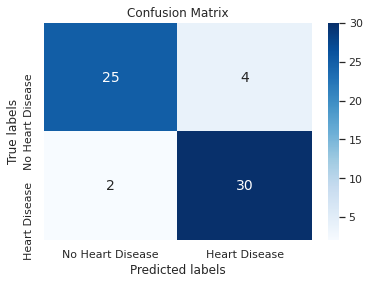

In [97]:
print("---------------------------------------------------------------------")
print('Test Accuracy Score: ' + str(accuracy_score(Y_test, df_ensemble.Ensemble.values)))
print("---------------------------------------------------------------------")
print('Classification Report: ')
print(classification_report(Y_test, df_ensemble.Ensemble.values))
print("---------------------------------------------------------------------")

cm = confusion_matrix(Y_test, df_ensemble.Ensemble.values)

ax= plt.subplot()
#plt.figure(figsize=(6,6))
sns.set(font_scale=1.0) # Adjust to fit
label_font = {'size':'5'}
plt.rcParams.update({'font.size': 14})
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(['No Heart Disease', 'Heart Disease'])
ax.yaxis.set_ticklabels(['No Heart Disease', 'Heart Disease'])
print("=====================================================================")

### Perfect! 

### I have also created a Inference Pipeline using Luigi and a Streamlit web app for real time predictions. 

You can try it at the below links - 


https://heart-disease-diagnostics.herokuapp.com/

https://github.com/Nikhilkohli1/Heart-Disease-Diagnosis-Assistant


Please upvote the kernel if you like it! 